<a href="https://colab.research.google.com/github/bharath3579/bharath3579-i.mobilothon-4.0---Round---II-Prototype-Submissions/blob/main/Copy_of_Aircraft_Predictive_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
maternusherold_pred_maintanance_data_path = kagglehub.dataset_download('maternusherold/pred-maintanance-data')

print('Data source import complete.')


100%|██████████| 1.32M/1.32M [00:00<00:00, 110MB/s]

Extracting files...
Data source import complete.


# Introduction.
The notebook aims to learn building RNN and LSTM networks for time-dependent variables.
While I was looking to learn building an LSTM like networks for continuous/time-dependent variables, I came across a very nice notebook ([link](https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb)). In this notebook most of the approach is taken from the mentioned notebook link and credit goes to original authors. <br>

Problem statement: Predict if an engine will fail within a particular cycle, given its history of cycles and sensory data. <br>

* Aircraft are very sensitive to the faults in their engines.
* Because of this, it is imperative to keep them in good condition for the safety of the passengers.
* Aircraft are very expensive and so is their maintenance.
* But at the same time, we do not want to overdo the maintenance aspect.
* If we do not detect a fault in time, it might become too expensive to maintain/repair the engines, or they might have to be replaced


The content of the notebooks are as below.
1. importing libs<br>
2. Load the Dataset <br>
3. Data Preprocessing<br>
    3.1. Generating the classification target variable<br>
    3.2. Normalizing the data set<br>
4.Exploratory Data Analysis - EDA<br>
5. Generating Input Sequence<br>
6. RNN Models<br>
    6.1 Simple RNN [1 Feature] <br>
    6.2 Simple RNN [25 Features] <br>
    6.3  Bi-Directional RNN [25 Features] <br>
7. Model Building with LSTM <br>
8. References

![image.png](attachment:fe04186a-4eaa-4cc2-9957-123070b8a8a9.png)

# 1. Importing libs

In [2]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU

In [3]:
# We will set the seed for reproducibility.
np.random.seed(1234)
PYTHONHASHSEED = 0

# 2. Load the Dataset

In [5]:
# Training data where the last cycle is the failure point for the engines
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)

# We wil print some rows of the train data
train_df.head(100)

0    1       2       3      4       5       6        7        8      9   \
0    1    1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1    1    2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2    1    3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3    1    4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4    1    5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   
..  ..  ...     ...     ...    ...     ...     ...      ...      ...    ...   
95   1   96 -0.0034  0.0001  100.0  518.67  642.19  1584.07  1395.16  14.62   
96   1   97  0.0035 -0.0003  100.0  518.67  642.07  1595.77  1407.81  14.62   
97   1   98  0.0006  0.0004  100.0  518.67  642.00  1591.11  1404.56  14.62   
98   1   99 -0.0005 -0.0000  100.0  518.67  642.46  1592.73  1406.13  14.62   
99   1  100 -0.0021 -0.0003  100.0  518.67  642.22  1589.63  1411.35  14.62   

    ...       18      19    20   21    22     23     24       25  26  27  
0   ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1   ...  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236 NaN NaN  
2   ...  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442 NaN NaN  
3   ...  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739 NaN NaN  
4   ...  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044 NaN NaN  
..  ...      ...     ...   ...  ...   ...    ...    ...      ...  ..  ..  
95  ...  8130.69  8.4311  0.03  392  2388  100.0  38.88  23.3255 NaN NaN  
96  ...  8128.74  8.4105  0.03  392  2388  100.0  39.01  23.2963 NaN NaN  
97  ...  8127.89  8.4012  0.03  391  2388  100.0  38.96  23.2554 NaN NaN  
98  ...  8131.77  8.4481  0.03  393  2388  100.0  38.82  23.2323 NaN NaN  
99  ...  8132.49  8.4241  0.03  392  2388  100.0  38.93  23.4090 NaN NaN  

[100 rows x 28 columns]

In [6]:
# Let's drop the NAN columns 26 and 27 using the dropna() method.
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

In [7]:
print(len(train_df))
print(len(test_df))

20631
13096


In [8]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

train_df.head(2)

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  

[2 rows x 26 columns]

In [9]:
test_df.head(2)

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1    0.0023    0.0003     100.0  518.67  643.02  1585.29  1398.21   
1   1      2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45  1395.42   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.72  2388.03  8125.55  8.4052  0.03  392  2388  100.0   
1  14.62  ...  522.16  2388.06  8139.62  8.3803  0.03  393  2388  100.0   

     s20      s21  
0  38.86  23.3735  
1  39.02  23.3916  

[2 rows x 26 columns]

In [10]:
# Load the ground truth for the test data, which indicates the remaining useful cycles for the engines

truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.head()

0   1
0  112 NaN
1   98 NaN
2   69 NaN
3   82 NaN
4   91 NaN

In [11]:
# We wil drop the NAN column
truth_df.dropna(axis=1, inplace=True)
truth_df.head()

0
0  112
1   98
2   69
3   82
4   91

# 3. Data Preprocessing
We will do the following while preprocessing the training dataset:

1. Generating the classification target variable
2. Normalizing the data set

## 3.1 Generating Classification Target Variable
We will classify the cycles close to breakdown with their respective ids as 1 in the target variable failure_within_w1.

Here, w1 signifies the window_1, which in this case is 30.

**IMP: In this case, during the last cycle the aircraft was in a bad state, and before the last cycle the aircraft indeed required maintenance. here predicting the x number of cycles before the aircraft brake down is very important.
the number of cycles before the actual breakdown we are referring to it as the window. In this case, the window can be 15, 30, 45 ..etc. it depends upon how early we want to flag the maintenance and the dependency on the accuracy.
In this case we are assuming window size as 30 (Aim to find if the maintenance requiered before 30 cycles) <br>**

![image.png](attachment:0faf6c70-801a-4a57-b9f9-bbcf5f7bcf53.png)

Sort the data set by id and cycles so each engine can have its values sorted and stored in one place. We use the sort_values()


In [12]:
# method and specify which columns are to be considered while sorting using the parameter.

train_df.sort_values(['id','cycle'], inplace=True)
test_df.sort_values(['id','cycle'], inplace=True)

First, we find the maximum cycles observed for each engine using groupby() and then merge these values for respective engine data using merge().

Then, we calculate the remaining useful life (RUL) by subtracting the current cycle value from the max. For example, a cycle has a total life of 192 cycles, and it has already run 50 cycles; hence, its RUL will be 192-50 = 142.



In [13]:
# Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
train_df['RUL'] = train_df['max'] - train_df['cycle']

#The RUL is calculated for each id.
train_df[['id','cycle','max','RUL']].head()

id  cycle  max  RUL
0   1      1  192  191
1   1      2  192  190
2   1      3  192  189
3   1      4  192  188
4   1      5  192  187

In [14]:
# We do not need "max" anymore.
train_df.drop('max', axis=1, inplace=True)

Generate label column for training data

In [15]:
# We will make a label that indicates whether an engine is going to fail within w1 cycles.
w1 = 30
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

## 3.2 Normalize Training Dataset

In [16]:
# Make a separate feature for the normalized value of the cycle column.
train_df['cycle_norm'] = train_df['cycle']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)

#Join the normalized and non-normalized data.
join_df = train_df[['id','cycle','RUL','failure_within_w1']].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.459770  0.166667       0.0  0.0  0.183735  0.406802  0.309757   
1   1      2  0.609195  0.250000       0.0  0.0  0.283133  0.453019  0.352633   
2   1      3  0.252874  0.750000       0.0  0.0  0.343373  0.369523  0.370527   
3   1      4  0.540230  0.500000       0.0  0.0  0.343373  0.256159  0.331195   
4   1      5  0.390805  0.333333       0.0  0.0  0.349398  0.257467  0.404625   

    s5  ...       s15  s16       s17  s18  s19       s20       s21  RUL  \
0  0.0  ...  0.363986  0.0  0.333333  0.0  0.0  0.713178  0.724662  191   
1  0.0  ...  0.411312  0.0  0.333333  0.0  0.0  0.666667  0.731014  190   
2  0.0  ...  0.357445  0.0  0.166667  0.0  0.0  0.627907  0.621375  189   
3  0.0  ...  0.166603  0.0  0.333333  0.0  0.0  0.573643  0.662386  188   
4  0.0  ...  0.402078  0.0  0.416667  0.0  0.0  0.589147  0.704502  187   

   failure_within_w1  cycle_norm  
0                  0     0.00000  
1                  0     0.00277  
2                  0     0.00554  
3                  0     0.00831  
4                  0     0.01108  

[5 rows x 29 columns]

Normalize the test data in the same manner that you normalized the training data.

In [17]:
# We will perform MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']

# MinMax normalization (from 0 to 1) of the sensor data only
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)

#Join the normalized and non-normalized data (it does not have 'RUL' and 'failure_within_w1')
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

Label the test set like we did for the training data.

In [18]:
# Let's calculate the total RUL by summing up the maximum cycles given in the test set and the
# ground truth additional RUL.
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['additional_rul']

# The respective id can be obtained by adding 1 to the index, as the index starts from 0.
truth_df['id'] = truth_df.index + 1

# Add the max cycles given in the test set and the additional RUL given in the ground truth DataFrame.
truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

# Generate the RUL for the test data.
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# Generate the label columns w0 and w1 for the test data.
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5  ...       s15  s16       s17  s18  s19       s20       s21  \
0  0.0  ...  0.308965  0.0  0.333333  0.0  0.0  0.558140  0.661834   
1  0.0  ...  0.213159  0.0  0.416667  0.0  0.0  0.682171  0.686827   
2  0.0  ...  0.458638  0.0  0.416667  0.0  0.0  0.728682  0.721348   
3  0.0  ...  0.257022  0.0  0.250000  0.0  0.0  0.666667  0.662110   
4  0.0  ...  0.300885  0.0  0.166667  0.0  0.0  0.658915  0.716377   

   cycle_norm  RUL  failure_within_w1  
0     0.00000  142                  0  
1     0.00277  141                  0  
2     0.00554  140                  0  
3     0.00831  139                  0  
4     0.01108  138                  0  

[5 rows x 29 columns]

# 4. Exploratory Data Analysis - EDA
Let's see how the sensor values change for a particular engine id, say id=1.


<Axes: >

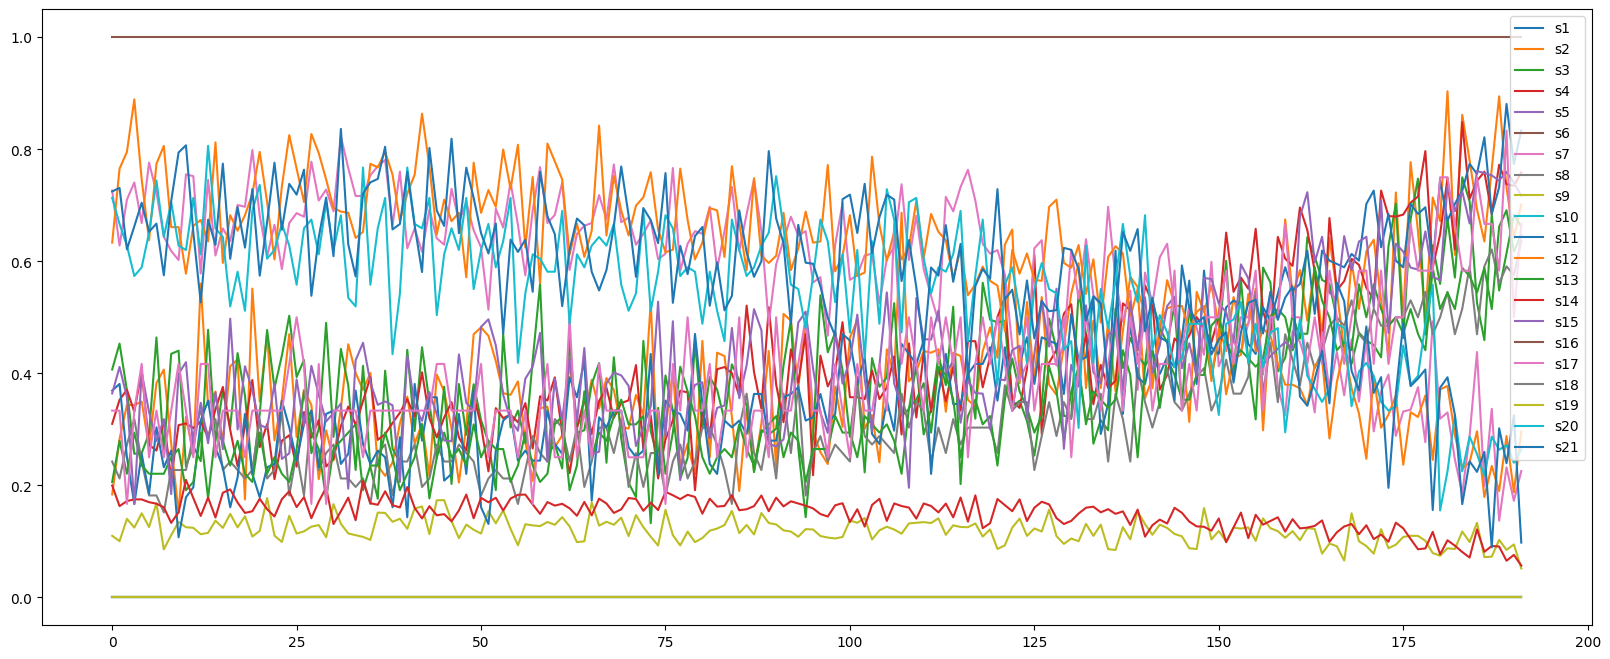

In [19]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(20, 8))

<Axes: >

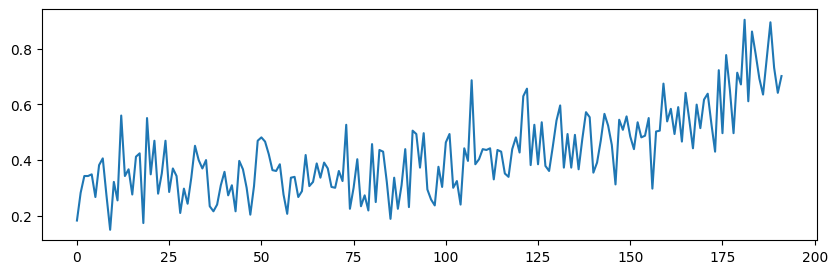

In [20]:
train_df[train_df.id==1][sensor_cols[1]].plot(figsize=(10, 3))

* Sensor 1 values increase when the cycle of number incrceases.
* Sensor 6 values decrease when the cycle of number increases.
* Most other sensors exhibit either an increasing or decreasing trend.


<Axes: >

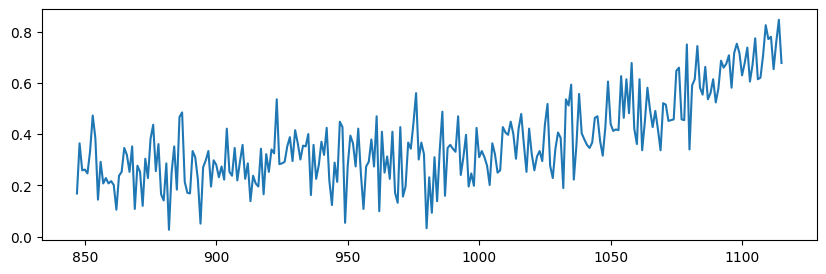

In [21]:
train_df[train_df.id==5][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

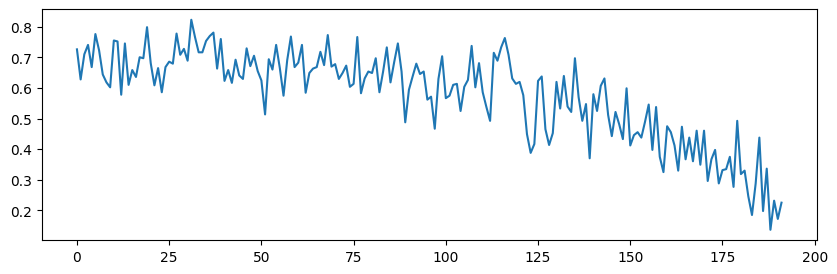

In [22]:
train_df[train_df.id==1][sensor_cols[6]].plot(figsize=(10, 3))

We have plotted sensor1 observations for id 1 and id 5.

Both observations have an upward trend with increasing cycles.

<Axes: >

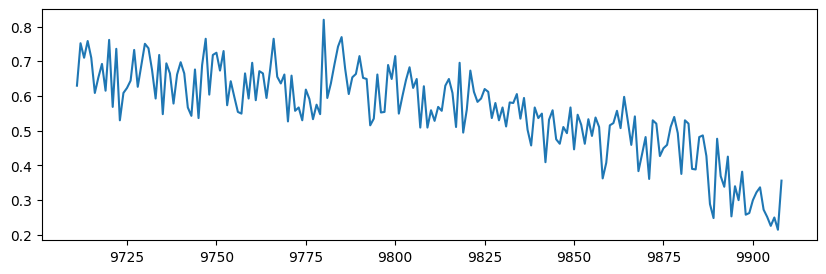

In [23]:
train_df[train_df.id==50][sensor_cols[6]].plot(figsize=(10, 3))

We have plotted sensor6 observations for id 1 and id 50.

Both observations have a downward trend with increasing cycles.

We can sew that when the sensor values approach a particular value, the aircraft may fail to work soon.

# 5. Generating Input Sequence


In [24]:
# The sequence length to be used for predictions is as follows:
sequence_length = 50

In [25]:
# The function to generate sequences (samples, time steps, features) for a particular engine id is as follows:

def sequence_generator(feature_df, seq_length, seq_cols):
    # We will not be using any sequence below seq_length.
    # Convert the DataFrame into a NumPy 2D array.
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]

    # We want to generate sequences of 50 timesteps at a time.
    # Hence, we will iterate over two sets of indices: (0,142),(50,192).
    # For example, id1 has 192 rows, and its sequence_length is equal to 50.
    # 0 50 -> From row 0 to row 50
    # 1 51 -> From row 1 to row 51
    # 2 52 -> From row 2 to row 52
    # ...
    # 141 191 -> From row 111 to 191

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [26]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, ["s2"])) # We take only one feature (s2).
           for id in train_df['id'].unique())

# Concatenate the sequences of different engine ids into one array and convert that into a NumPy array
# [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
#print(list(seq_gen))
seq_set = np.concatenate(list(seq_gen)).astype(np.float32)

# Let’s print the shape of the seq_set  (number of samples, number of time steps, number of features)
seq_set.shape

(15631, 50, 1)

In [27]:
# The function to generate labels is as follows:
def label_generator(label_df, seq_length, label):
    # Funtion will return
    # This function will return the following:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    # Convert the labels into a NumPy 2D array.

    label_array = label_df[label].values
    num_elements = label_array.shape[0]
        # Remove the first label, as the first prediction will be the (seq_length+1)th label.
    return label_array[seq_length:num_elements, :]

In [28]:
# Generate labels [[142,1], [121, 1], [3]] --> [1, 2, 3] (ntotal, 1).
label_gen = [label_generator(train_df[train_df['id']==id], sequence_length, ['failure_within_w1'])
             for id in train_df['id'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)
label_set.shape

(15631, 1)

# 6. RNN Models
We will build, train, and evaluate the following models:

* Simple RNN [1 Feature] <br>
* Simple RNN [25 Features] <br>
* Bi-Directional RNN [25 Features] <br>

## 6.1 Simple RNN [1 Feature]

In [29]:
out_dim = label_set.shape[1] # 1 label/output for one sequence.
features_dim = seq_set.shape[2] # Number of features (1)


print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd = Sequential()

# Add the RNN unit.
# Understand the parameters.
RNN_fwd.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=1,
         return_sequences=False))
RNN_fwd.add(Dropout(0.2))

RNN_fwd.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd.summary())

# Define the path to save the model.
RNN_fwd_path = '/kaggle/working/RNN_fwd.h5'

Features dimension:  1
Output dimension:  1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
import time
epochs = 300
batch_size = 200
start = time.time()
RNN_fwd_path = '/kaggle/working/RNN_fwd.keras'
# Fit the network.
RNN_fwd_history = RNN_fwd.fit(seq_set, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/300
75/75 - 4s - 58ms/step - accuracy: 0.5718 - loss: 0.6960 - val_accuracy: 0.5921 - val_loss: 0.6695
Epoch 2/300
75/75 - 1s - 12ms/step - accuracy: 0.6934 - loss: 0.6380 - val_accuracy: 0.6739 - val_loss: 0.6218
Epoch 3/300
75/75 - 1s - 17ms/step - accuracy: 0.7482 - loss: 0.5950 - val_accuracy: 0.7174 - val_loss: 0.5880
Epoch 4/300
75/75 - 1s - 15ms/step - accuracy: 0.7697 - loss: 0.5649 - val_accuracy: 0.7558 - val_loss: 0.5543
Epoch 5/300
75/75 - 1s - 14ms/step - accuracy: 0.7765 - loss: 0.5481 - val_accuracy: 0.7532 - val_loss: 0.5447
Epoch 6/300
75/75 - 1s - 8ms/step - accuracy: 0.7754 - loss: 0.5401 - val_accuracy: 0.7583 - val_loss: 0.5340
Epoch 7/300
75/75 - 1s - 9ms/step - accuracy: 0.7813 - loss: 0.5282 - val_accuracy: 0.7685 - val_loss: 0.5216
Epoch 8/300
75/75 - 1s - 8ms/step - accuracy: 0.7893 - loss: 0.5184 - val_accuracy: 0.7698 - val_loss: 0.5164
Epoch 9/300
75/75 - 1s - 7ms/step - accuracy: 0.7890 - loss: 0.5143 - val_accuracy: 0.7685 - val_loss: 0.5137
Epoch

**Model Evaluation on the Train and Validation Sets**

In [32]:
# The function for plotting the change in the model’s accuracy on the train and validation sets is as follows:
def plot_model_accuracy(model_name_history, width = 10, height = 10):

  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['accuracy'])
  plt.plot(model_name_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

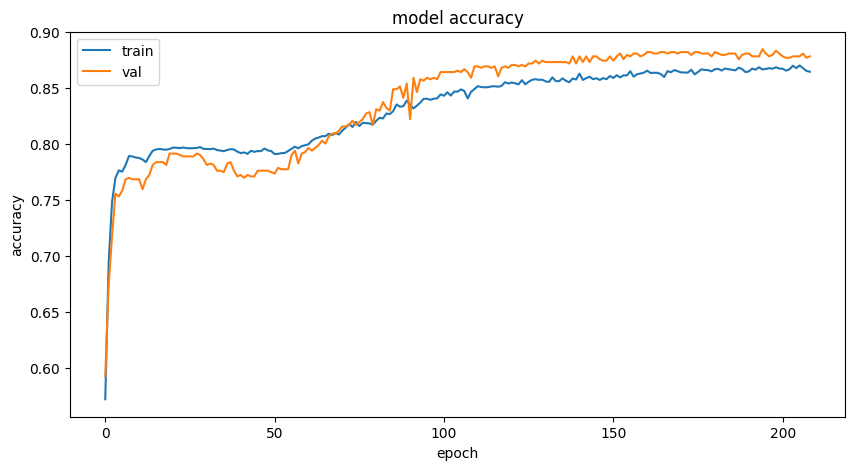

In [33]:
#Call the function.
plot_model_accuracy(RNN_fwd_history,10,5)

**Training Curve**

In [34]:
# We will define a function to plot the change in the loss on the train and validation sets.
def plot_training_curve(model_name_history, width = 10, height = 10):
  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['loss'])
  plt.plot(model_name_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

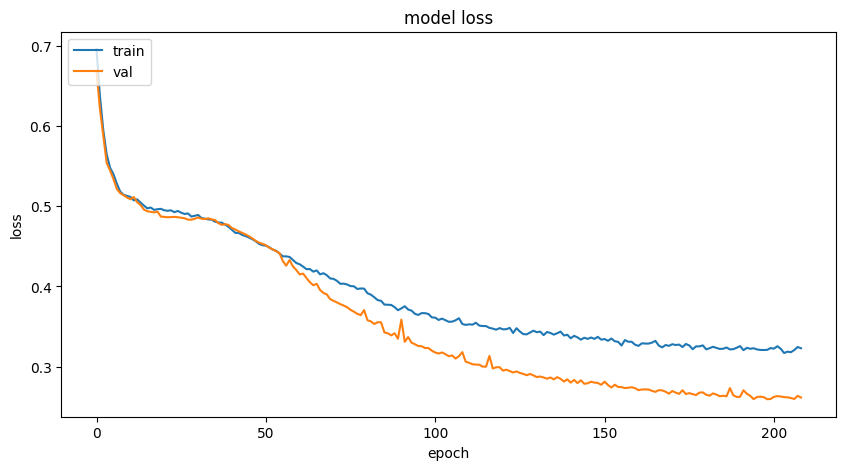

In [35]:
#Call the function.
plot_training_curve(RNN_fwd_history,10,5)

**Model Evaluation on the Train Set**

In [36]:
def analyze_model_on_train_set(input_sequence_set, model_name):

  # The training metrics are as follows:
  model_history_scores = model_name.evaluate(input_sequence_set, label_set, verbose=1, batch_size=50)
  print('Train Accurracy: {}'.format(model_history_scores[1]))

  # Make predictions and compute the confusion matrix.
  y_pred = (model_name.predict(input_sequence_set, verbose=1, batch_size=200) > 0.5).astype("int32")
  y_true = label_set

  test_set = pd.DataFrame(y_pred)
  test_set.to_csv('binary_submit_train.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_cm = confusion_matrix(y_true, y_pred)
  print(model_cm)

  # Compute the precision and recall.
  model_precision = precision_score(y_true, y_pred)
  model_recall = recall_score(y_true, y_pred)
  print( 'Train Precision = ', model_precision, '\n', 'Train Recall = ', model_recall)

# Call the function.
analyze_model_on_train_set(seq_set, RNN_fwd)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8825 - loss: 0.2735
Train Accurracy: 0.8801740407943726
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12164   367]
 [ 1506  1594]]
Train Precision =  0.8128505864354921 
 Train Recall =  0.5141935483870967


**Model evaluation on test set**

In [37]:
def analyze_model_on_test_set(input_sequence_columns, model_path, width= 10, height=5):
  # We will consider all the last sequences of the test set.
  last_test_seq = [test_df[test_df['id']==id][input_sequence_columns].values[-sequence_length:]
                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
  last_test_seq = np.asarray(last_test_seq).astype(np.float32)

  # Get the labels of the test set.
  y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
  last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
  last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

  # If the best model weights were saved, load them.
  if os.path.isfile(model_path):
    print("using " + model_path)
    model_estimator = load_model(model_path)

  # Test the metrics.
  start = time.time()
  scores_test = model_estimator.evaluate(last_test_seq, last_test_label, verbose=2)
  end = time.time()
  print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

  print('Test Accurracy: {}'.format(scores_test[1]))

  # Make predictions and compute the confusion matrix.
  y_model_estimator_pred_test = (model_estimator.predict(last_test_seq) >0.5).astype("int32")
  y_true_test = last_test_label

  test_set = pd.DataFrame(y_model_estimator_pred_test)
  test_set.to_csv('binary_submit_test.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_estimator_conf_m = confusion_matrix(y_true_test, y_model_estimator_pred_test)
  print(model_estimator_conf_m)

  # Compute the precision and recall values.
  model_estimator_precision_test = precision_score(y_true_test, y_model_estimator_pred_test)
  model_estimator_recall_test = recall_score(y_true_test, y_model_estimator_pred_test)
  f1_test = 2 * (model_estimator_precision_test * model_estimator_recall_test) / (model_estimator_precision_test + model_estimator_recall_test)
  print( 'Test Precision: ', model_estimator_precision_test, '\n', 'Test Recall: ', model_estimator_recall_test,'\n', 'Test F1-score:', f1_test )

  # Plot the predicted data in blue and the
  # actual data in green to visually verify the accuracy of the model.
  fig_verify = plt.figure(figsize=(10, 5))
  plt.plot(y_model_estimator_pred_test, color="blue")
  plt.plot(y_true_test, color="green")
  plt.title('prediction')
  plt.ylabel('value')
  plt.xlabel('row')
  plt.legend(['predicted', 'actual data'], loc='upper left')
  plt.show()

using /kaggle/working/RNN_fwd.keras
3/3 - 1s - 217ms/step - accuracy: 0.8387 - loss: 0.3448
Total time taken for inferencing:  0.79  secs
Test Accurracy: 0.8387096524238586
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [13 12]]
Test Precision:  0.8571428571428571 
 Test Recall:  0.48 
 Test F1-score: 0.6153846153846153


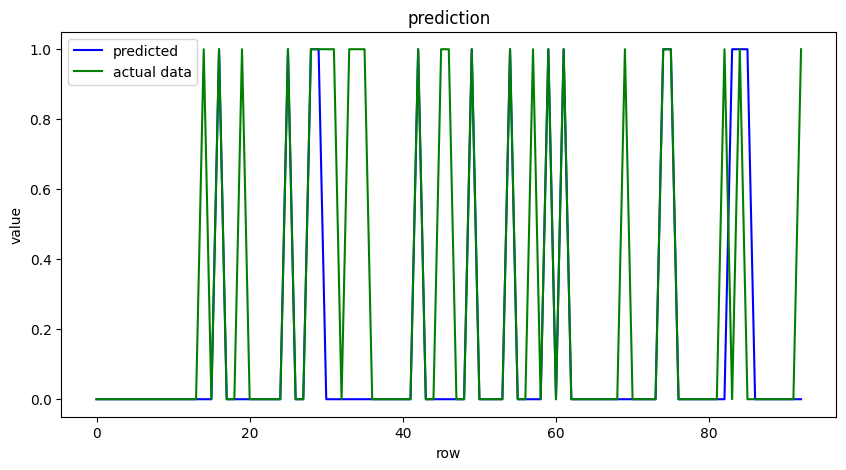

In [38]:
#Call the function.
analyze_model_on_test_set(["s2"], RNN_fwd_path, 10, 5)

## 6.2 Simple RNN With 25 Features
Let's now consider data from all 21 sensors and 3 settings as well.
This will lead to 25 features in the input sequence set.

In [39]:
# Pick the feature columns.
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols_25 = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols_25.extend(sensor_cols) # Add the elements of sensor_cols into sequence_cols.

In [40]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, sequence_cols_25)) #We will take all the features (25).
           for id in train_df['id'].unique())

# Concatenate the sequences of the different engine ids into one and convert it into a NumPy array [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
seq_set_f25 = np.concatenate(list(seq_gen)).astype(np.float32)

#The shape denotes (number of samples, number of time steps, number of features).
seq_set_f25.shape

(15631, 50, 25)

In [41]:
features_dim = seq_set_f25.shape[2] # number of features (25).
out_dim = label_set.shape[1] # One label (failure_within_w1).

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd_2 = Sequential()

# Understanding return_sequences and the connection across RNN layers:
# We have to return the sequences from the first layer so the next layer can get the sequence.

RNN_fwd_2.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=5,
         return_sequences=True))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd_2.summary())

# Define the path to save the model.
RNN_fwd_2_path = '/kaggle/working/RNN_fwd_2.h5'

Features dimension:  25
Output dimension:  1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 50, 5)               │             155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 3)                   │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186 (744.00 B)

 Trainable params: 186 (744.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [42]:
import time
epochs = 200
batch_size = 200
start = time.time()
RNN_fwd_2_path = '/kaggle/working/RNN_fwd_2.keras'
# Fit the network.
RNN_fwd_2_history = RNN_fwd_2.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_2_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 8s - 108ms/step - accuracy: 0.8223 - loss: 0.4394 - val_accuracy: 0.9054 - val_loss: 0.3150
Epoch 2/200
75/75 - 3s - 38ms/step - accuracy: 0.8931 - loss: 0.3199 - val_accuracy: 0.9156 - val_loss: 0.2638
Epoch 3/200
75/75 - 2s - 27ms/step - accuracy: 0.9097 - loss: 0.2780 - val_accuracy: 0.9194 - val_loss: 0.2432
Epoch 4/200
75/75 - 2s - 24ms/step - accuracy: 0.9180 - loss: 0.2557 - val_accuracy: 0.9194 - val_loss: 0.2240
Epoch 5/200
75/75 - 2s - 20ms/step - accuracy: 0.9253 - loss: 0.2376 - val_accuracy: 0.9233 - val_loss: 0.2133
Epoch 6/200
75/75 - 2s - 26ms/step - accuracy: 0.9249 - loss: 0.2268 - val_accuracy: 0.9233 - val_loss: 0.2134
Epoch 7/200
75/75 - 4s - 56ms/step - accuracy: 0.9303 - loss: 0.2140 - val_accuracy: 0.9258 - val_loss: 0.2027
Epoch 8/200
75/75 - 4s - 57ms/step - accuracy: 0.9310 - loss: 0.2054 - val_accuracy: 0.9271 - val_loss: 0.2008
Epoch 9/200
75/75 - 4s - 56ms/step - accuracy: 0.9310 - loss: 0.1996 - val_accuracy: 0.9297 - val_loss: 0.1908


**Plot Model Accuracy for the Train and Validation Sets**

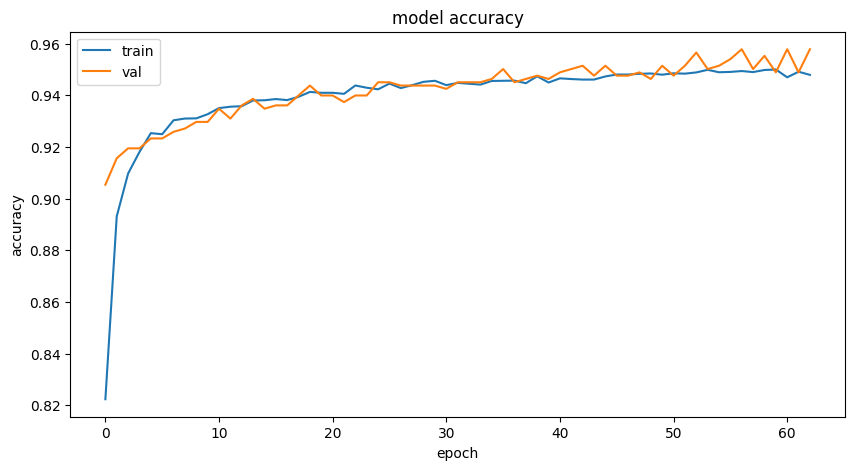

In [43]:
plot_model_accuracy(RNN_fwd_2_history, 10, 5)

**Training Curve**

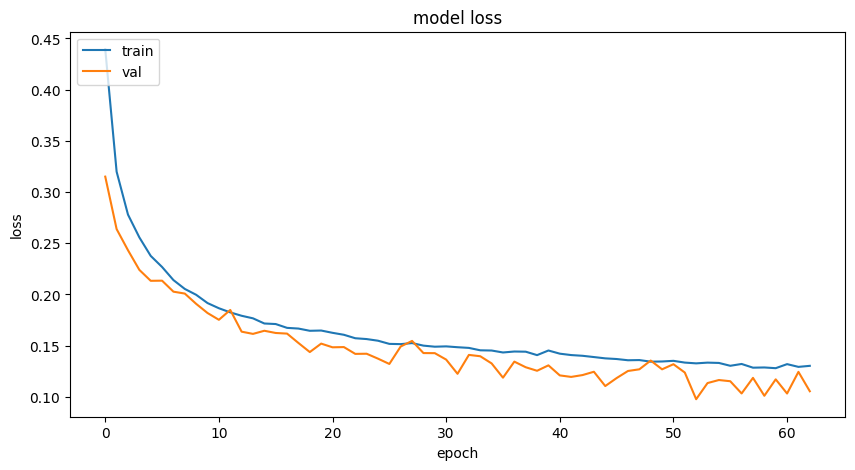

In [44]:
plot_training_curve(RNN_fwd_2_history,10,5)

**Model Evaluation on Train Set**

In [45]:
analyze_model_on_train_set(seq_set_f25, RNN_fwd_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9588 - loss: 0.0956
Train Accurracy: 0.9534258842468262


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12194   337]
 [  391  2709]]
Train Precision =  0.8893630991464215 
 Train Recall =  0.8738709677419355


**Model Evaluation on Test Set**

using /kaggle/working/RNN_fwd_2.keras
3/3 - 1s - 186ms/step - accuracy: 0.9140 - loss: 0.1938
Total time taken for inferencing:  0.62  secs
Test Accurracy: 0.9139785170555115
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 6 19]]
Test Precision:  0.9047619047619048 
 Test Recall:  0.76 
 Test F1-score: 0.8260869565217391


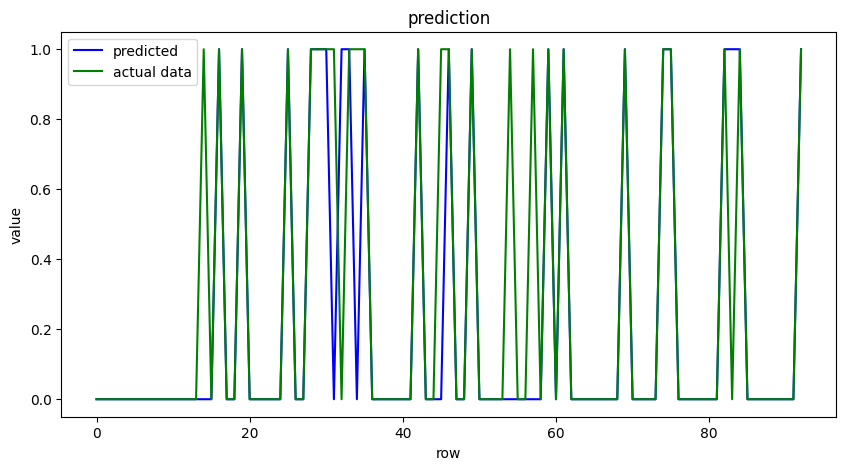

In [46]:
analyze_model_on_test_set(sequence_cols_25, RNN_fwd_2_path, 10, 5)

## 6.3 Bidirectional RNN

You saw how to build ForwardRNN models with SimpleRNN units.

Let's now create a bidirectional RNN model.


In [47]:
#Import a bidirectional library.
from tensorflow.keras.layers import Bidirectional

features_dim = seq_set_f25.shape[2] # Number of features (25)
out_dim = label_set.shape[1] # One output for each sequence (failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_bi = Sequential()

# Understanding return_sequences and the connection across RNN layers
# Note that we have to return the sequence from the first layer so the next layer can get the sequence.

RNN_bi.add(Bidirectional( #We need to pass the RNN unit as an argument of the Bidirectional() function.
         SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=6,
         return_sequences=True)))
RNN_bi.add(Dropout(0.2))

RNN_bi.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_bi.add(Dropout(0.2))

RNN_bi.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the path to save the model.
RNN_bi_path = '/kaggle/working/RNN_bi.h5'

Features dimension:  25
Output dimension:  1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
import time
epochs = 200
batch_size = 200
start = time.time()

RNN_bi_path = '/kaggle/working/RNN_bi.keras'
# Fit the network
RNN_bi_history = RNN_bi.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_bi_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")



Epoch 1/200
75/75 - 8s - 113ms/step - accuracy: 0.8236 - loss: 0.4067 - val_accuracy: 0.9246 - val_loss: 0.2658
Epoch 2/200
75/75 - 4s - 47ms/step - accuracy: 0.9016 - loss: 0.2928 - val_accuracy: 0.9143 - val_loss: 0.2475
Epoch 3/200
75/75 - 3s - 34ms/step - accuracy: 0.9179 - loss: 0.2601 - val_accuracy: 0.9297 - val_loss: 0.2150
Epoch 4/200
75/75 - 2s - 30ms/step - accuracy: 0.9252 - loss: 0.2390 - val_accuracy: 0.9322 - val_loss: 0.2028
Epoch 5/200
75/75 - 3s - 38ms/step - accuracy: 0.9285 - loss: 0.2217 - val_accuracy: 0.9437 - val_loss: 0.1735
Epoch 6/200
75/75 - 4s - 48ms/step - accuracy: 0.9278 - loss: 0.2111 - val_accuracy: 0.9425 - val_loss: 0.1771
Epoch 7/200
75/75 - 2s - 29ms/step - accuracy: 0.9298 - loss: 0.2018 - val_accuracy: 0.9412 - val_loss: 0.1717
Epoch 8/200
75/75 - 3s - 34ms/step - accuracy: 0.9327 - loss: 0.1949 - val_accuracy: 0.9488 - val_loss: 0.1514
Epoch 9/200
75/75 - 2s - 33ms/step - accuracy: 0.9340 - loss: 0.1901 - val_accuracy: 0.9514 - val_loss: 0.1529


In [49]:
#Print the summary of the model.
print(RNN_bi.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 50, 12)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50, 12)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 3)                   │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,310 (5.12 KB)

 Trainable params: 436 (1.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 874 (3.42 KB)

None


**Plot model accuracy for train and validation set**

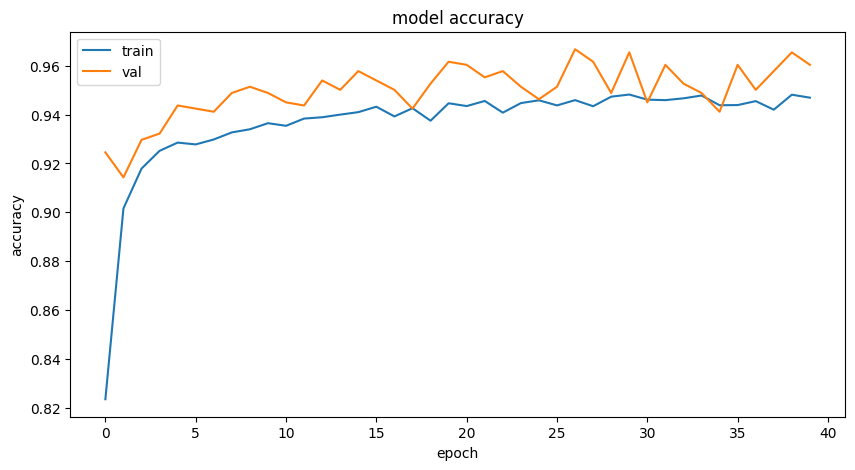

In [50]:
plot_model_accuracy(RNN_bi_history,10,5)

**Training curve**

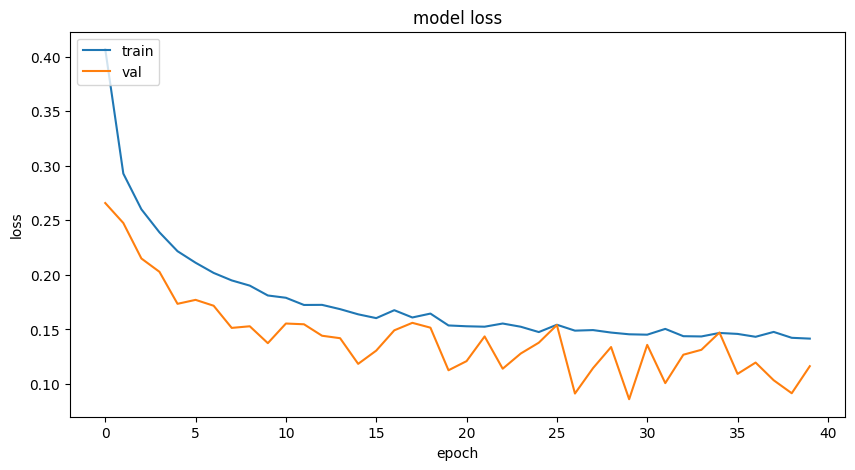

In [51]:
plot_training_curve(RNN_bi_history,10,5)

**Model Evaluation on train set**

In [52]:
analyze_model_on_train_set(seq_set_f25, RNN_bi)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9603 - loss: 0.1043
Train Accurracy: 0.9589277505874634


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12303   228]
 [  414  2686]]
Train Precision =  0.9217570350034318 
 Train Recall =  0.8664516129032258


**Model Evaluation on test set**

using /kaggle/working/RNN_bi.keras
3/3 - 1s - 363ms/step - accuracy: 0.9140 - loss: 0.1911
Total time taken for inferencing:  1.19  secs
Test Accurracy: 0.9139785170555115
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 6 19]]
Test Precision:  0.9047619047619048 
 Test Recall:  0.76 
 Test F1-score: 0.8260869565217391


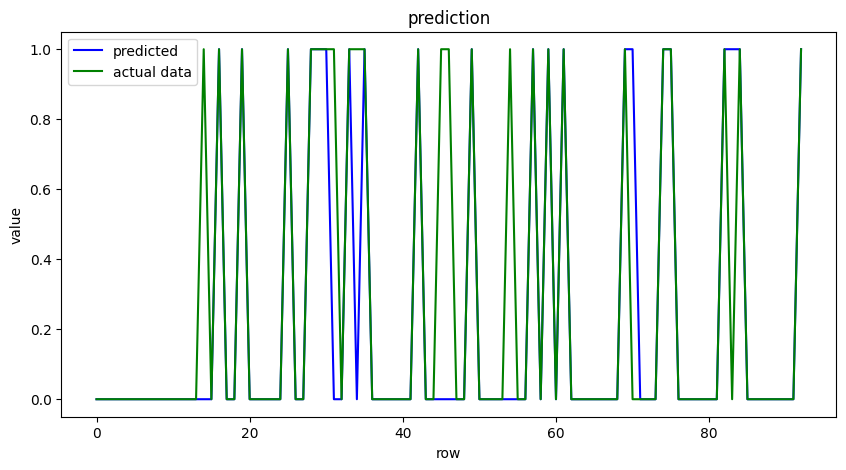

In [53]:
analyze_model_on_test_set(sequence_cols_25, RNN_bi_path,10,5)

### RNN Summary
1. The performance of the RNN with one feature on the test set is worse than that of a more complex RNN.
2. RNN model with increased units with all 25 features achieves better accuracy and other evaluation metrics
3. When we use more than one layer, the previous layer must be set to return_sequences = True.

# 7. Model Building with LSTM

In [54]:
# Model - (100 LSTM units with 0.2 dropout) +
#         (50 LSTM units with 0.2 dropout) +
#         (dense layer with sigmoid activation)

features_dim = seq_set_f25.shape[2] # number of features
out_dim = label_set.shape[1] # 1 Label (Target variable is failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

model = Sequential()

# Understanding of return_sequences and connection across LSTM layers
model.add(LSTM(
         input_shape=(sequence_length, features_dim),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Define path to save model
model_path = '/kaggle/working/binary_model.h5'

Features dimension:  25
Output dimension:  1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 100)             │          50,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,651 (315.04 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [55]:
import time
epochs = 200
batch_size = 200
start = time.time()

model_path = '/kaggle/working/binary_model.keras'
# Fit the network
history = model.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 29s - 386ms/step - accuracy: 0.8880 - loss: 0.2719 - val_accuracy: 0.9105 - val_loss: 0.1605
Epoch 2/200
75/75 - 18s - 242ms/step - accuracy: 0.9509 - loss: 0.1217 - val_accuracy: 0.9629 - val_loss: 0.0778
Epoch 3/200
75/75 - 22s - 288ms/step - accuracy: 0.9672 - loss: 0.0794 - val_accuracy: 0.9770 - val_loss: 0.0511
Epoch 4/200
75/75 - 19s - 254ms/step - accuracy: 0.9736 - loss: 0.0622 - val_accuracy: 0.9859 - val_loss: 0.0368
Epoch 5/200
75/75 - 21s - 284ms/step - accuracy: 0.9737 - loss: 0.0634 - val_accuracy: 0.9783 - val_loss: 0.0447
Epoch 6/200
75/75 - 20s - 262ms/step - accuracy: 0.9711 - loss: 0.0678 - val_accuracy: 0.9770 - val_loss: 0.0577
Epoch 7/200
75/75 - 21s - 280ms/step - accuracy: 0.9754 - loss: 0.0586 - val_accuracy: 0.9872 - val_loss: 0.0290
Epoch 8/200
75/75 - 20s - 266ms/step - accuracy: 0.9759 - loss: 0.0573 - val_accuracy: 0.9821 - val_loss: 0.0397
Epoch 9/200
75/75 - 23s - 305ms/step - accuracy: 0.9768 - loss: 0.0584 - val_accuracy: 0.9719 - 

**Model Evaluation on Validation set**


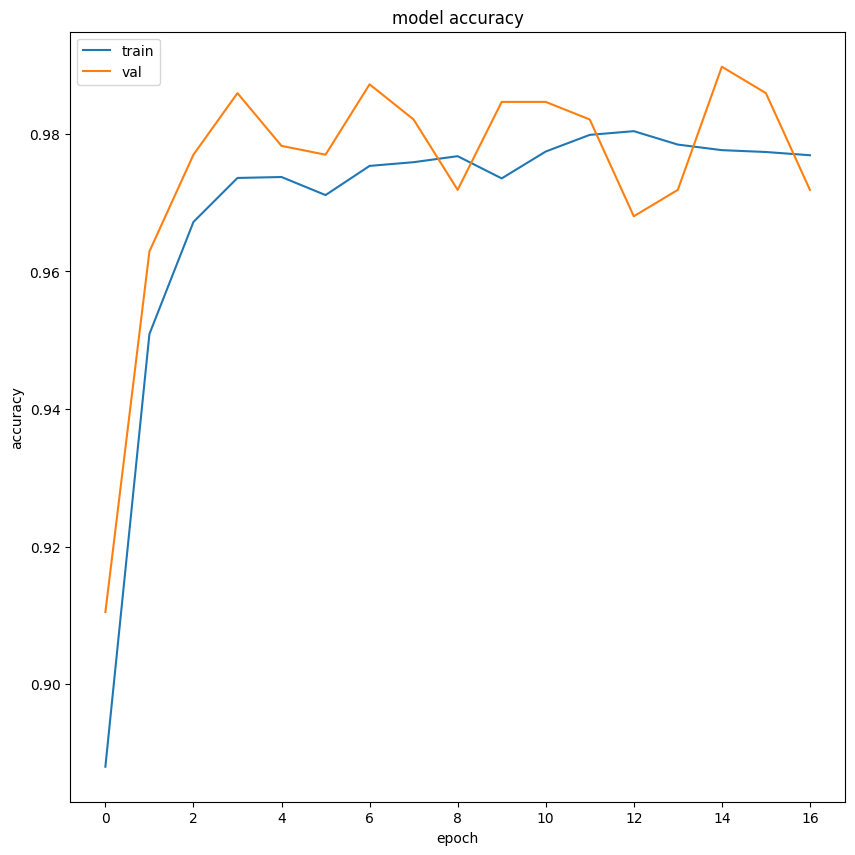

In [56]:
# Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

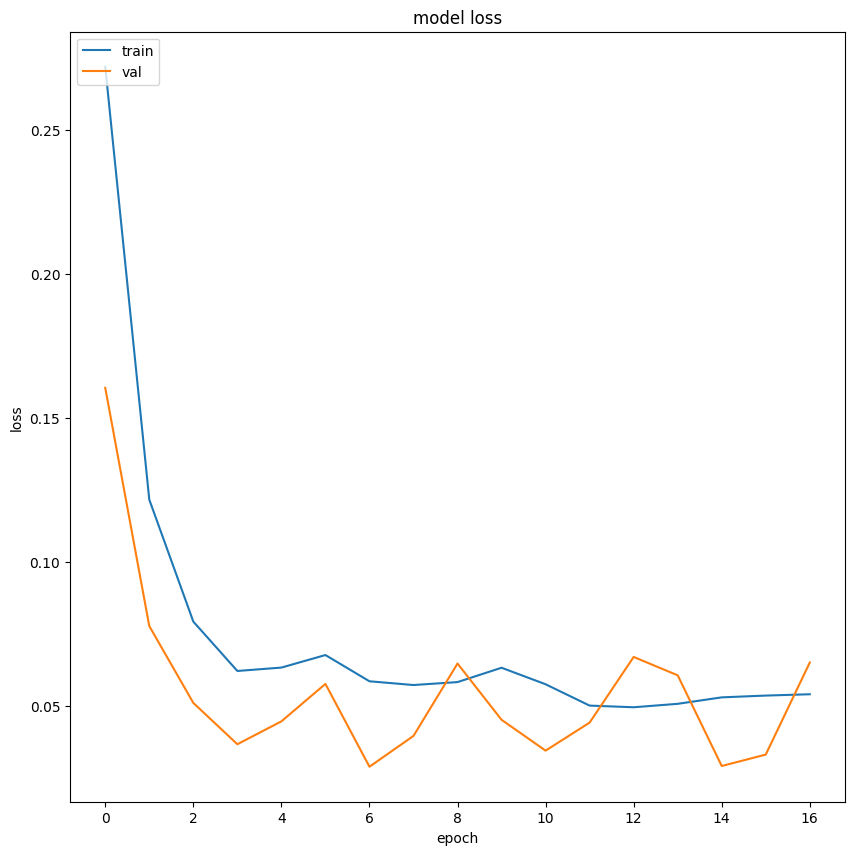

In [57]:
# Plot model loss for train and test sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [58]:
# Training metrics
scores = model.evaluate(seq_set_f25, label_set, verbose=1, batch_size=50)
print('Train Accurracy: {}'.format(scores[1]))

# Make predictions and compute confusion matrix
y_pred = (model.predict(seq_set_f25, verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_set

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Train Precision = ', precision, '\n', 'Train Recall = ', recall)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9763 - loss: 0.0541
Train Accurracy: 0.9753054976463318
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12472    59]
 [  327  2773]]
Train Precision =  0.9791666666666666 
 Train Recall =  0.8945161290322581


**Model Evaluation on Test set**

3/3 - 1s - 232ms/step - accuracy: 0.9892 - loss: 0.0461
Total time taken for inferencing:  0.75  secs
Test Accurracy: 0.9892473220825195
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[68  0]
 [ 1 24]]
Test Precision:  1.0 
 Test Recall:  0.96 
 Test F1-score: 0.9795918367346939


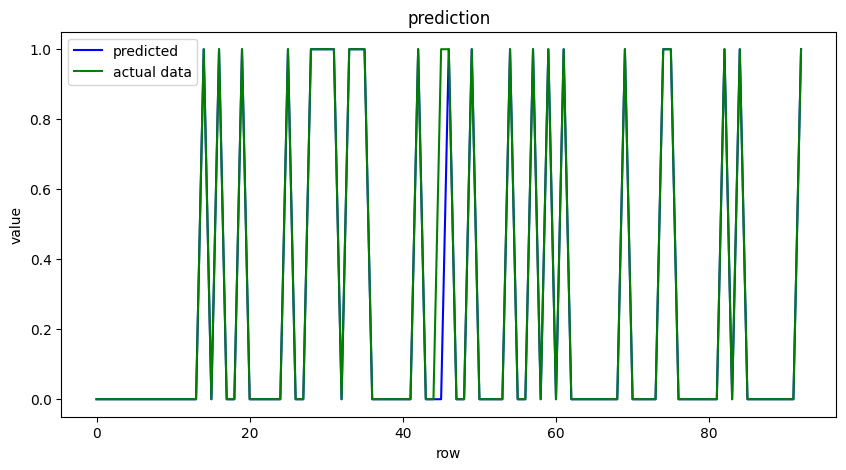

In [59]:
# Considering all the last sequences of test set
last_test_seq = [test_df[test_df['id']==id][sequence_cols_25].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)

# Get labels of test set
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

# If best model weights were saved then load it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# Test metrics
start = time.time()
scores_test = estimator.evaluate(last_test_seq, last_test_label, verbose=2)
end = time.time()
print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

print('Test Accurracy: {}'.format(scores_test[1]))

# Make predictions and compute confusion matrix
y_pred_test = (estimator.predict(last_test_seq) > 0.5).astype("int32")
y_true_test = last_test_label

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
conf_m = confusion_matrix(y_true_test, y_pred_test)
print(conf_m)

# Compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test,'\n', 'Test F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# Actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()

In [60]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import preprocessing

# Load the data
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)

# Print the number of columns in each dataset
print(f"Number of columns in train_df: {train_df.shape[1]}")
print(f"Number of columns in test_df: {test_df.shape[1]}")
print(f"Number of columns in truth_df: {truth_df.shape[1]}")
print("\nFirst few rows of truth_df:")
print(truth_df.head())

# Generate column names based on the actual number of columns
cols = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, train_df.shape[1] - 4)]

# Assign column names
train_df.columns = cols
test_df.columns = cols

# Drop any NaN columns
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

# Data preprocessing for train data
def add_rul_and_label(df):
    # Calculate RUL
    rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    df = df.merge(rul, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop('max', axis=1, inplace=True)

    # Add failure label
    w1 = 30
    df['failure_within_w1'] = np.where(df['RUL'] <= w1, 1, 0)

    return df

train_df = add_rul_and_label(train_df)

# Normalize the data
train_df['cycle_norm'] = train_df['cycle']
test_df['cycle_norm'] = test_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'failure_within_w1'])

min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

# Prepare the features and labels
features = [col for col in train_df.columns if col.startswith('s') or col.startswith('setting')] + ['cycle_norm']
X_train = train_df[features]
y_train = train_df['failure_within_w1']

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf_model.predict(X_train)

# Evaluate the model on the training set
print("\nTraining Set Performance:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-score: {f1_score(y_train, y_train_pred):.4f}")

# Confusion matrix for training set
cm_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix - Training Set:")
print(cm_train)

# Prepare test set
last_sequence = test_df.groupby('id').last().reset_index()[features]

# Make predictions on the last sequence of each engine
y_pred = rf_model.predict(last_sequence)

# Prepare truth data
truth_df.columns = ['RUL', 'max_cycle']  # Adjust this based on the actual content of truth_df
y_true = (truth_df['RUL'] <= 30).astype(int)

print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1-score: {f1_score(y_true, y_pred):.4f}")

# Confusion matrix for test set
cm_test = confusion_matrix(y_true, y_pred)
print("Confusion Matrix - Test Set:")
print(cm_test)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Number of columns in train_df: 28
Number of columns in test_df: 28
Number of columns in truth_df: 2

First few rows of truth_df:
     0   1
0  112 NaN
1   98 NaN
2   69 NaN
3   82 NaN
4   91 NaN

Training Set Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Confusion Matrix - Training Set:
[[17531     0]
 [    0  3100]]

Test Set Performance:
Accuracy: 0.9100
Precision: 0.9000
Recall: 0.7200
F1-score: 0.8000
Confusion Matrix - Test Set:
[[73  2]
 [ 7 18]]

Top 10 Most Important Features:
   feature  importance
13     s11    0.167253
6       s4    0.149347
17     s15    0.099779
14     s12    0.094243
9       s7    0.079619
23     s21    0.064753
11      s9    0.055603
16     s14    0.051297
22     s20    0.042352
4       s2    0.039862


In [61]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the data
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)

# Print the number of columns and first few rows of truth_df
print(f"Number of columns in train_df: {train_df.shape[1]}")
print(f"Number of columns in test_df: {test_df.shape[1]}")
print(f"Number of columns in truth_df: {truth_df.shape[1]}")
print("\nFirst few rows of truth_df:")
print(truth_df.head())

# Generate column names
cols = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, train_df.shape[1] - 4)]
train_df.columns = cols
test_df.columns = cols

# Drop any NaN columns
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

# Data preprocessing for train data
def add_rul_and_label(df):
    rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    df = df.merge(rul, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop('max', axis=1, inplace=True)

    w1 = 30
    df['failure_within_w1'] = np.where(df['RUL'] <= w1, 1, 0)

    return df

train_df = add_rul_and_label(train_df)

# Prepare features
features = [col for col in train_df.columns if col.startswith('s') or col.startswith('setting')] + ['cycle']
X_train = train_df[features]
y_train = train_df['failure_within_w1']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Make predictions on the training set
y_train_pred = lr_model.predict(X_train_scaled)

# Evaluate the model on the training set
print("\nTraining Set Performance:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-score: {f1_score(y_train, y_train_pred):.4f}")

# Confusion matrix for training set
cm_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix - Training Set:")
print(cm_train)

# Prepare test set
last_sequence = test_df.groupby('id').last().reset_index()[features]
X_test_scaled = scaler.transform(last_sequence)

# Make predictions on the last sequence of each engine
y_pred = lr_model.predict(X_test_scaled)

# Prepare truth data
truth_df.columns = ['RUL', 'max_cycle']  # Adjust this based on what you see in the truth_df output
y_true = (truth_df['RUL'] <= 30).astype(int)

print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1-score: {f1_score(y_true, y_pred):.4f}")

# Confusion matrix for test set
cm_test = confusion_matrix(y_true, y_pred)
print("Confusion Matrix - Test Set:")
print(cm_test)

# Feature importance (coefficients for logistic regression)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': np.abs(lr_model.coef_[0])
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Number of columns in train_df: 28
Number of columns in test_df: 28
Number of columns in truth_df: 2

First few rows of truth_df:
     0   1
0  112 NaN
1   98 NaN
2   69 NaN
3   82 NaN
4   91 NaN

Training Set Performance:
Accuracy: 0.9622
Precision: 0.8906
Recall: 0.8535
F1-score: 0.8717
Confusion Matrix - Training Set:
[[17206   325]
 [  454  2646]]

Test Set Performance:
Accuracy: 0.9300
Precision: 1.0000
Recall: 0.7200
F1-score: 0.8372
Confusion Matrix - Test Set:
[[75  0]
 [ 7 18]]

Top 10 Most Important Features:
   feature  importance
13     s11    1.101925
11      s9    0.910752
10      s8    0.868250
15     s13    0.805165
14     s12    0.802242
24   cycle    0.788981
16     s14    0.737789
6       s4    0.586365
9       s7    0.532366
17     s15    0.358059


In [62]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the data
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)

# Print the number of columns and first few rows of truth_df
print(f"Number of columns in train_df: {train_df.shape[1]}")
print(f"Number of columns in test_df: {test_df.shape[1]}")
print(f"Number of columns in truth_df: {truth_df.shape[1]}")
print("\nFirst few rows of truth_df:")
print(truth_df.head())

# Generate column names
cols = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, train_df.shape[1] - 4)]
train_df.columns = cols
test_df.columns = cols

# Drop any NaN columns
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

# Data preprocessing for train data
def add_rul_and_label(df):
    rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    df = df.merge(rul, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop('max', axis=1, inplace=True)

    w1 = 30
    df['failure_within_w1'] = np.where(df['RUL'] <= w1, 1, 0)

    return df

train_df = add_rul_and_label(train_df)

# Prepare features
features = [col for col in train_df.columns if col.startswith('s') or col.startswith('setting')] + ['cycle']
X_train = train_df[features]
y_train = train_df['failure_within_w1']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the training set
y_train_pred = xgb_model.predict(X_train_scaled)

# Evaluate the model on the training set
print("\nTraining Set Performance:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-score: {f1_score(y_train, y_train_pred):.4f}")

# Confusion matrix for training set
cm_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix - Training Set:")
print(cm_train)

# Prepare test set
last_sequence = test_df.groupby('id').last().reset_index()[features]
X_test_scaled = scaler.transform(last_sequence)

# Make predictions on the last sequence of each engine
y_pred = xgb_model.predict(X_test_scaled)

# Prepare truth data
truth_df.columns = ['RUL', 'max_cycle']  # Adjust this based on what you see in the truth_df output
y_true = (truth_df['RUL'] <= 30).astype(int)

print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1-score: {f1_score(y_true, y_pred):.4f}")

# Confusion matrix for test set
cm_test = confusion_matrix(y_true, y_pred)
print("Confusion Matrix - Test Set:")
print(cm_test)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Number of columns in train_df: 28
Number of columns in test_df: 28
Number of columns in truth_df: 2

First few rows of truth_df:
     0   1
0  112 NaN
1   98 NaN
2   69 NaN
3   82 NaN
4   91 NaN


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:02:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training Set Performance:
Accuracy: 0.9999
Precision: 1.0000
Recall: 0.9990
F1-score: 0.9995
Confusion Matrix - Training Set:
[[17531     0]
 [    3  3097]]

Test Set Performance:
Accuracy: 0.9200
Precision: 0.9048
Recall: 0.7600
F1-score: 0.8261
Confusion Matrix - Test Set:
[[73  2]
 [ 6 19]]

Top 10 Most Important Features:
   feature  importance
13     s11    0.587434
6       s4    0.090985
11      s9    0.059122
14     s12    0.039825
9       s7    0.028316
16     s14    0.028285
24   cycle    0.021542
17     s15    0.019195
23     s21    0.018434
15     s13    0.016954


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:02:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


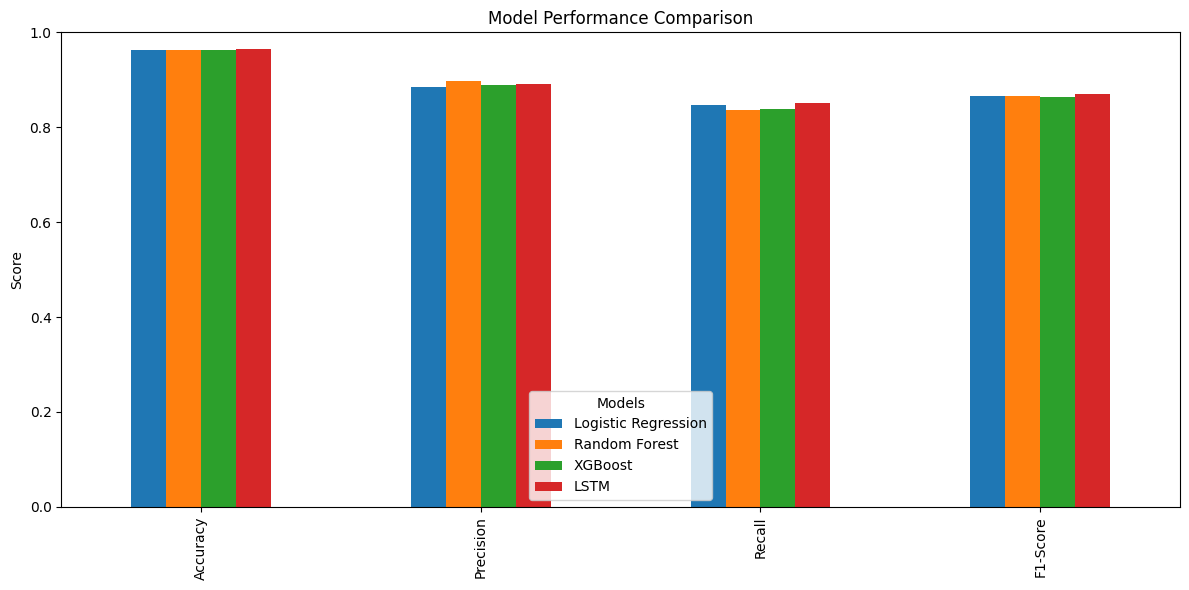

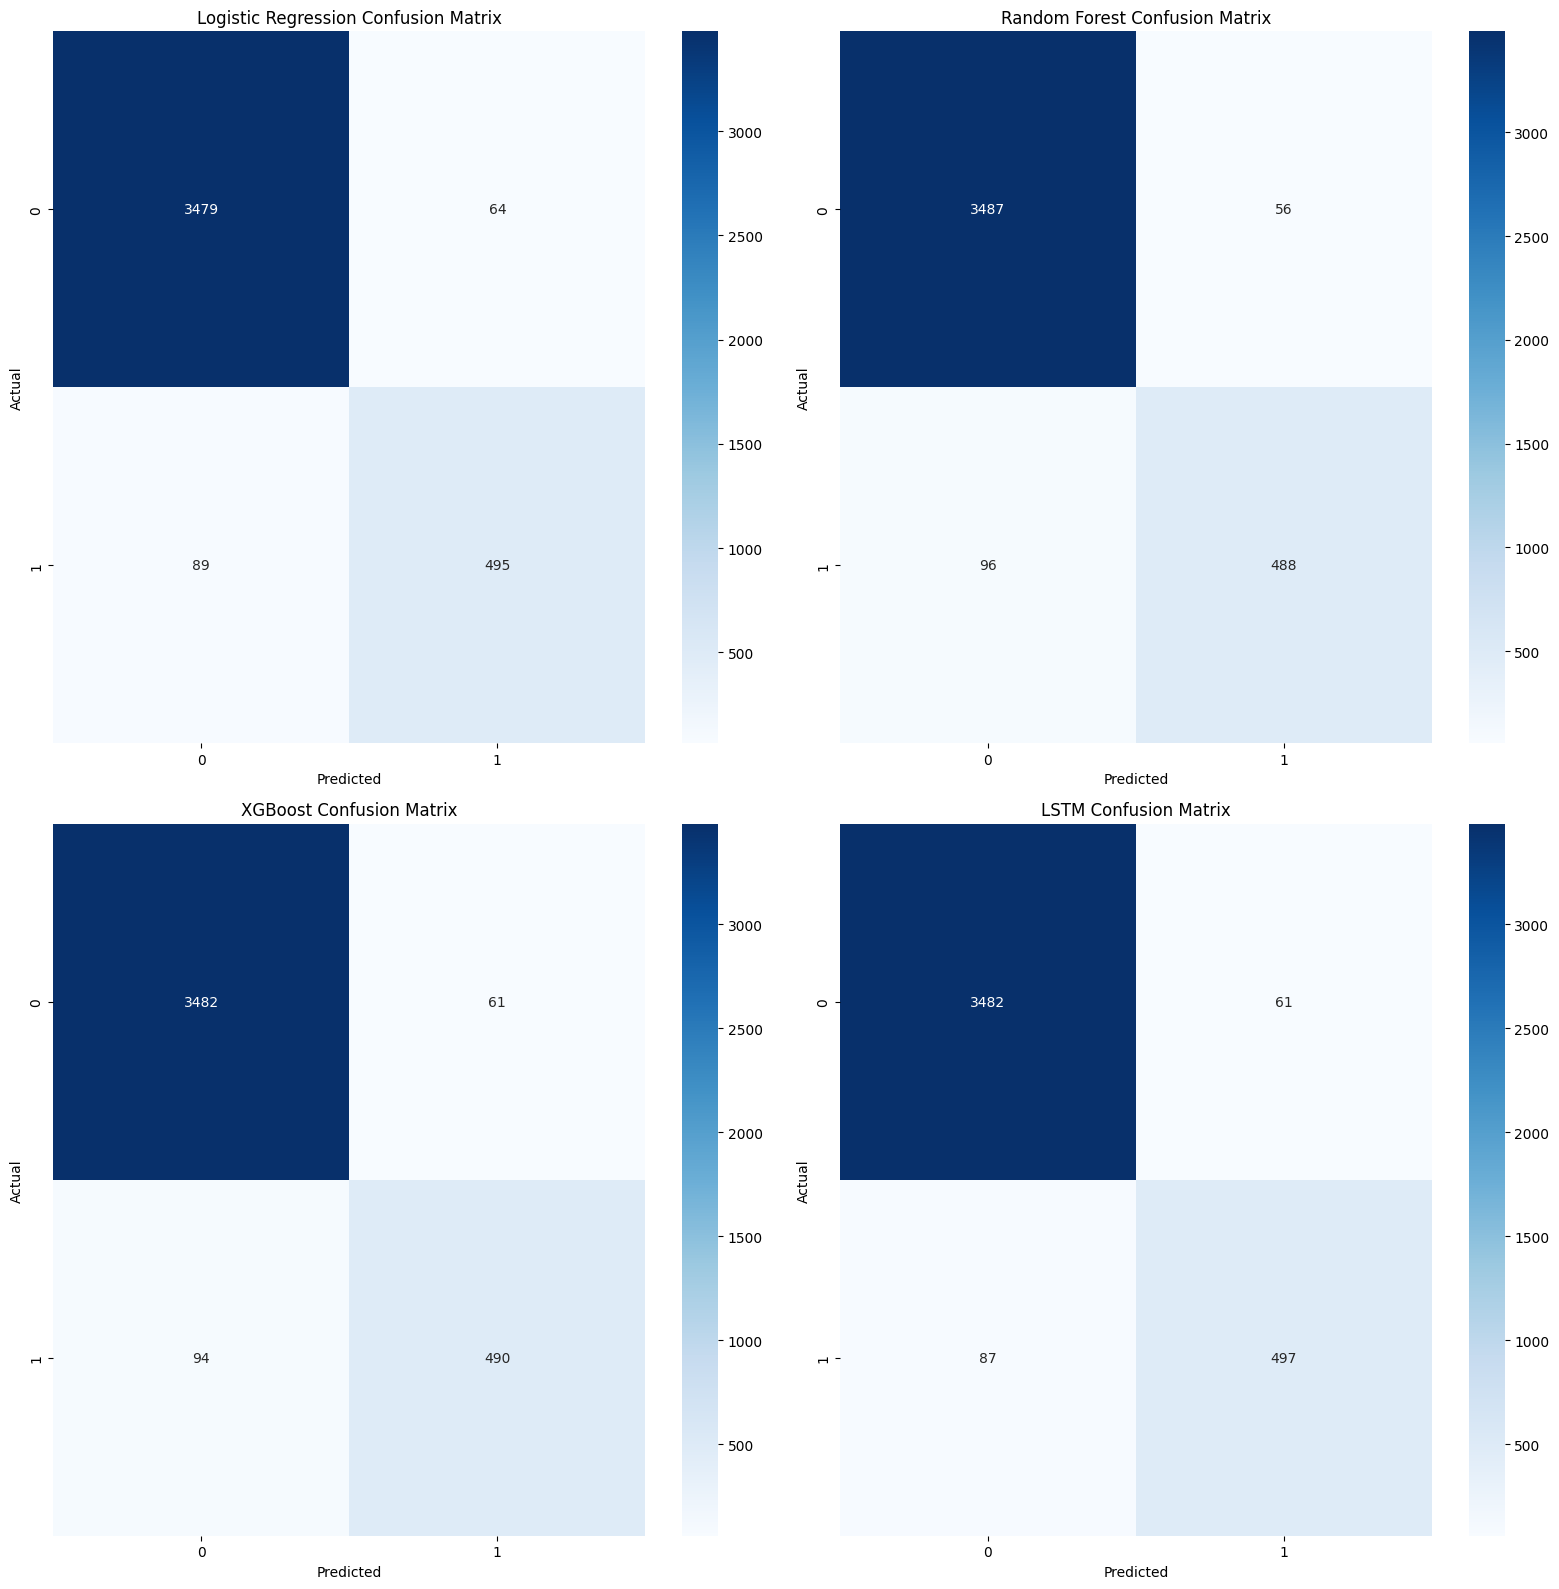

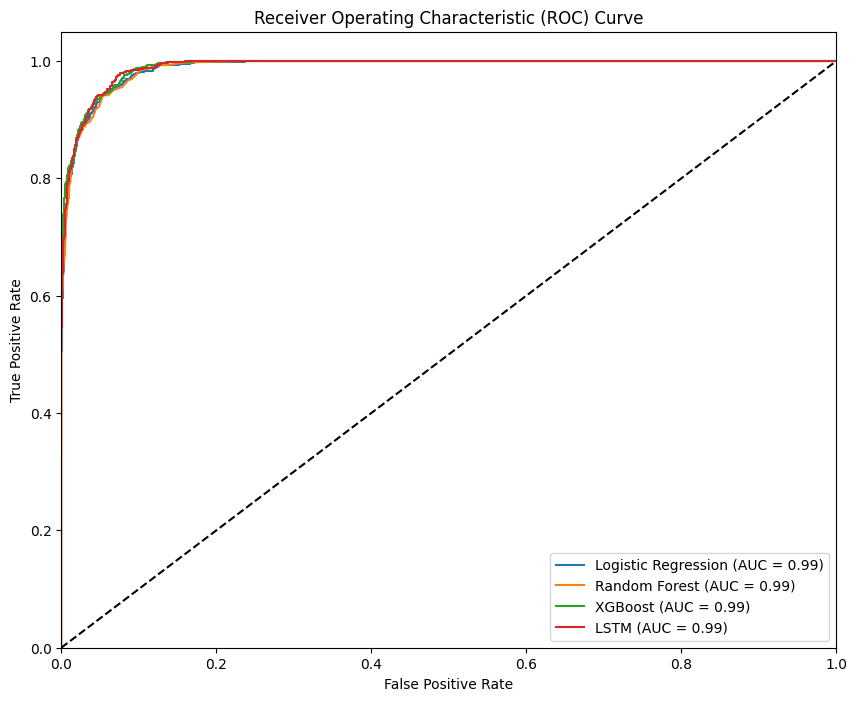

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Load the data
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)

# Generate column names
cols = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, train_df.shape[1] - 4)]
train_df.columns = cols
test_df.columns = cols

# Drop any NaN columns
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

# Data preprocessing for train data
def add_rul_and_label(df):
    rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    df = df.merge(rul, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop('max', axis=1, inplace=True)

    w1 = 30
    df['failure_within_w1'] = np.where(df['RUL'] <= w1, 1, 0)

    return df

train_df = add_rul_and_label(train_df)

# Prepare features and target
features = [col for col in train_df.columns if col.startswith('s') or col.startswith('setting')] + ['cycle']
X = train_df[features]
y = train_df['failure_within_w1']

# Function to create and train models
def create_and_train_models(X_train, y_train):
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Logistic Regression
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train_scaled, y_train)

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # XGBoost
    xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train_scaled, y_train)

    # LSTM
    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    lstm_model = Sequential([
        LSTM(50, input_shape=(1, X_train_scaled.shape[1]), return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)

    return lr_model, rf_model, xgb_model, lstm_model, scaler

# Function to get predictions and probabilities
def get_predictions(models, X, scaler):
    X_scaled = scaler.transform(X)
    lr_model, rf_model, xgb_model, lstm_model = models

    lr_pred = lr_model.predict(X_scaled)
    lr_prob = lr_model.predict_proba(X_scaled)[:, 1]

    rf_pred = rf_model.predict(X_scaled)
    rf_prob = rf_model.predict_proba(X_scaled)[:, 1]

    xgb_pred = xgb_model.predict(X_scaled)
    xgb_prob = xgb_model.predict_proba(X_scaled)[:, 1]

    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    lstm_prob = lstm_model.predict(X_lstm).ravel()
    lstm_pred = (lstm_prob > 0.5).astype(int)

    return {
        'Logistic Regression': (lr_pred, lr_prob),
        'Random Forest': (rf_pred, rf_prob),
        'XGBoost': (xgb_pred, xgb_prob),
        'LSTM': (lstm_pred, lstm_prob)
    }

# Function to plot performance metrics
def plot_performance_metrics(y_true, predictions):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    results = {model: [] for model in predictions.keys()}

    for model, (y_pred, _) in predictions.items():
        results[model].append(accuracy_score(y_true, y_pred))
        results[model].append(precision_score(y_true, y_pred))
        results[model].append(recall_score(y_true, y_pred))
        results[model].append(f1_score(y_true, y_pred))

    results_df = pd.DataFrame(results, index=metrics)

    plt.figure(figsize=(12, 6))
    results_df.plot(kind='bar', ax=plt.gca())
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(title='Models')
    plt.tight_layout()
    plt.show()

# Function to plot confusion matrices
def plot_confusion_matrices(y_true, predictions):
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    axes = axes.ravel()

    for i, (model, (y_pred, _)) in enumerate(predictions.items()):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(f'{model} Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Function to plot ROC curves
def plot_roc_curves(y_true, predictions):
    plt.figure(figsize=(10, 8))

    for model, (_, y_prob) in predictions.items():
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Main execution
if __name__ == "__main__":
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train models
    models = create_and_train_models(X_train, y_train)

    # Get predictions
    test_predictions = get_predictions(models[:-1], X_test, models[-1])

    # Plot performance metrics
    plot_performance_metrics(y_test, test_predictions)

    # Plot confusion matrices
    plot_confusion_matrices(y_test, test_predictions)

    # Plot ROC curves
    plot_roc_curves(y_test, test_predictions)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:03:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Engines requiring maintenance within 30 cycles:
Engine 81: Probability of failure = 100.00%


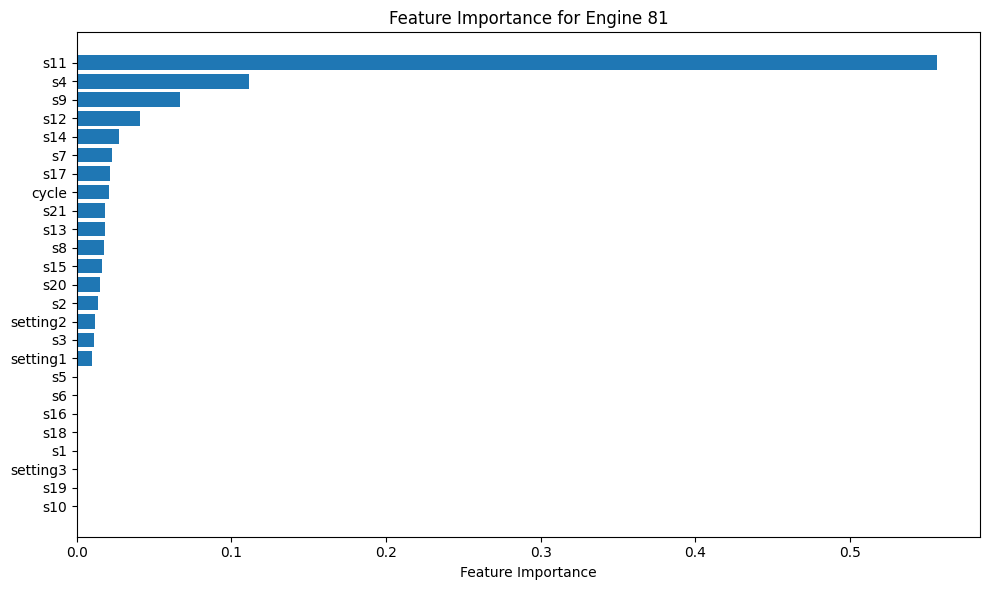

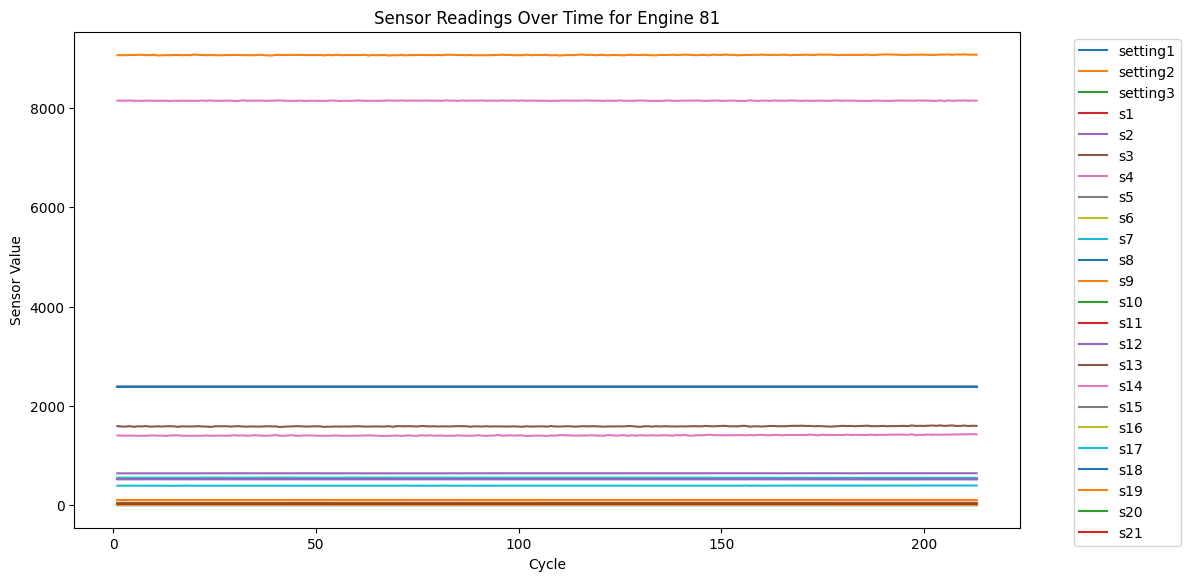



Engine 100: Probability of failure = 100.00%


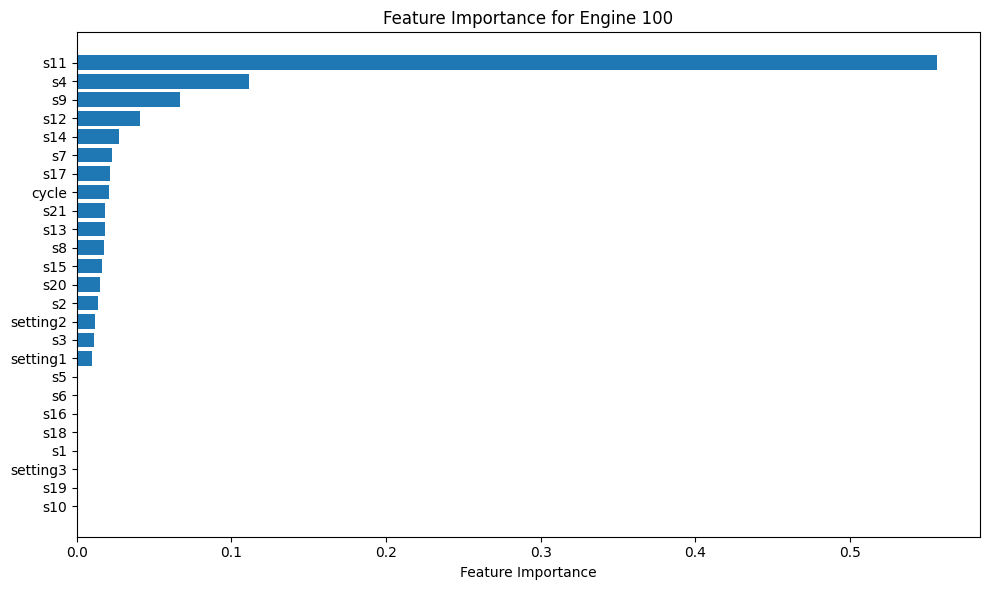

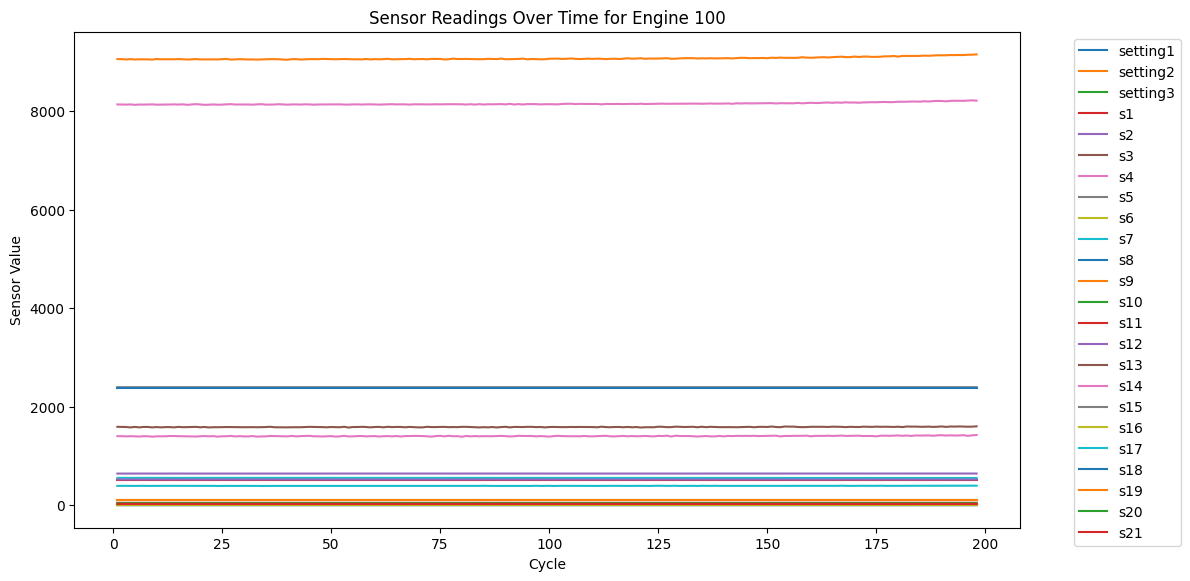



Engine 34: Probability of failure = 100.00%


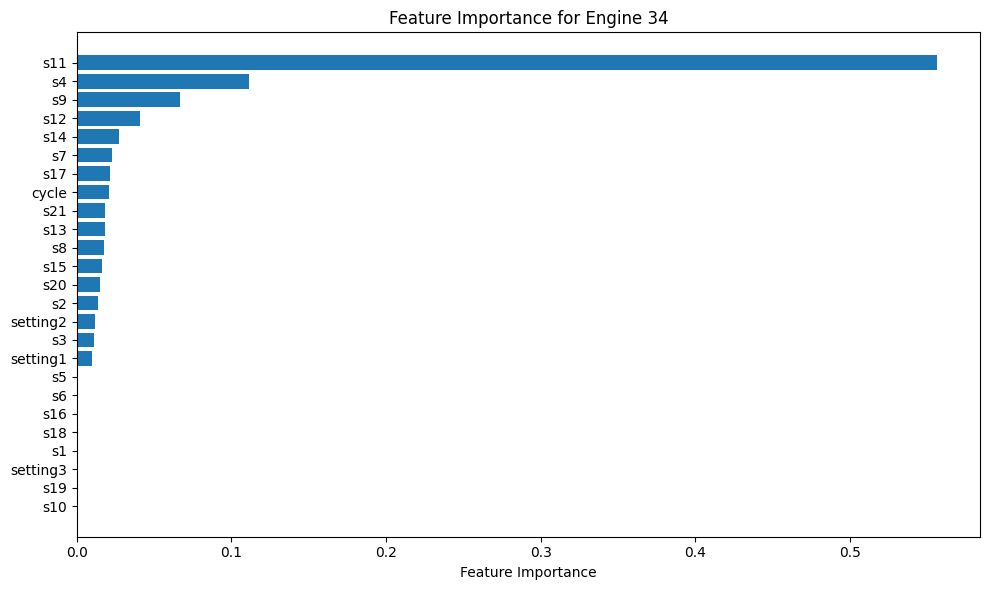

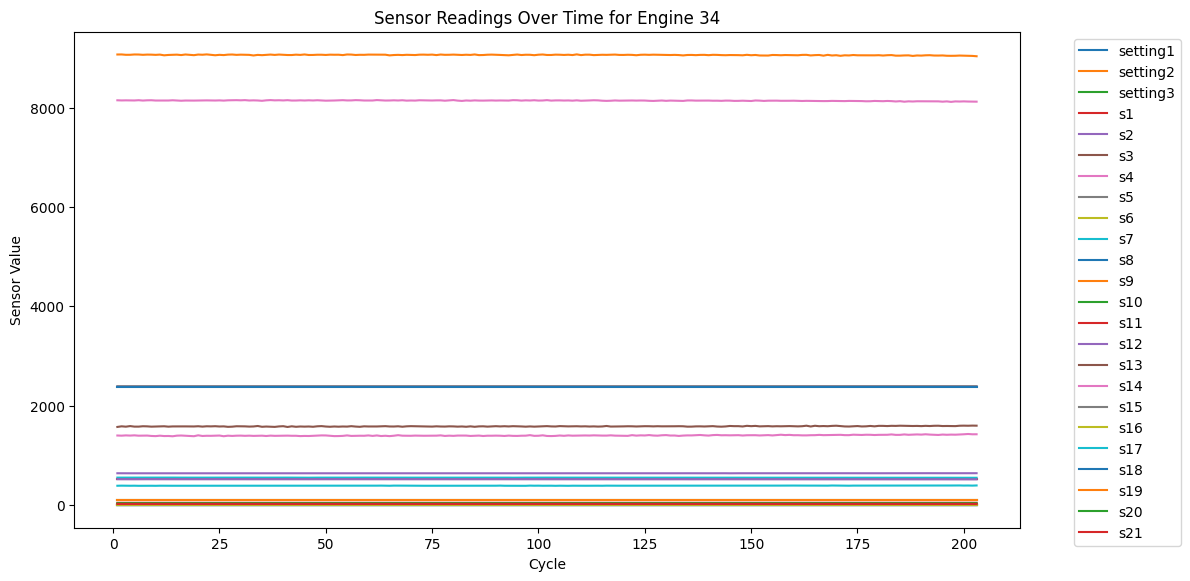



Engine 66: Probability of failure = 99.99%


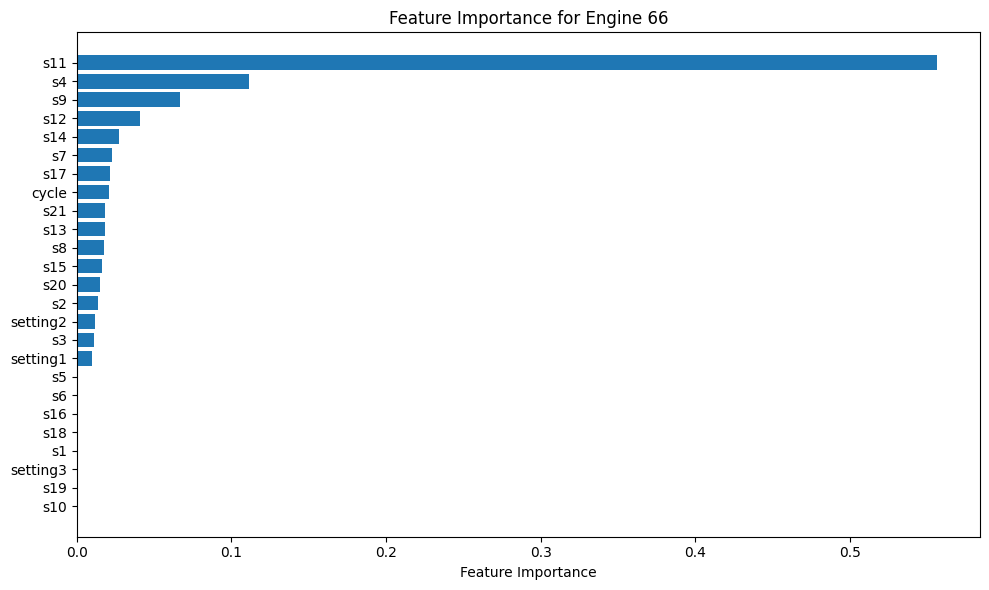

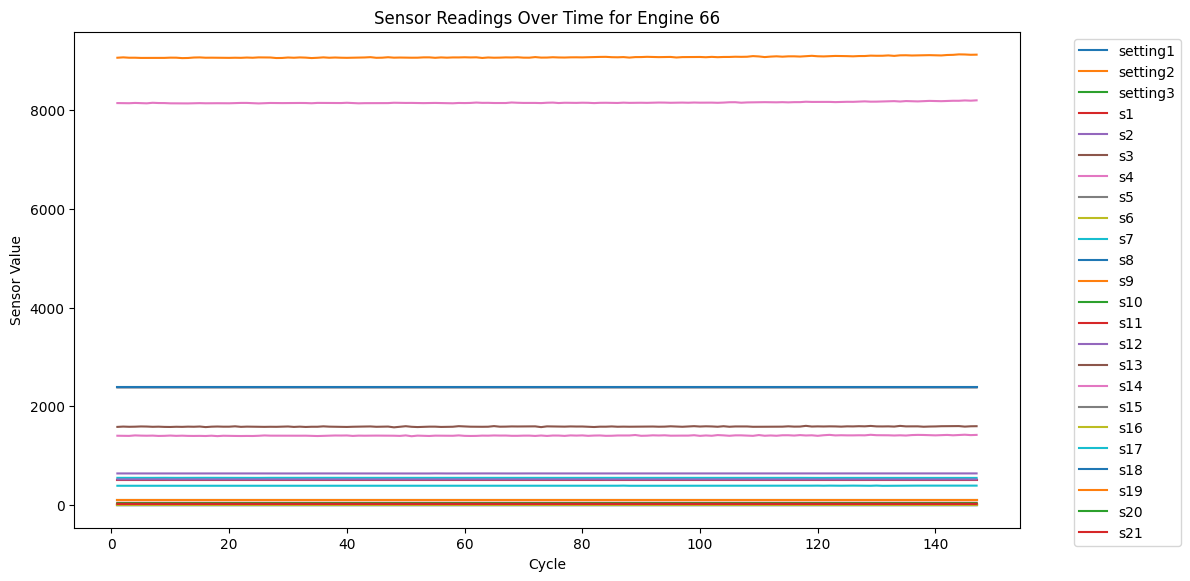



Engine 35: Probability of failure = 99.99%


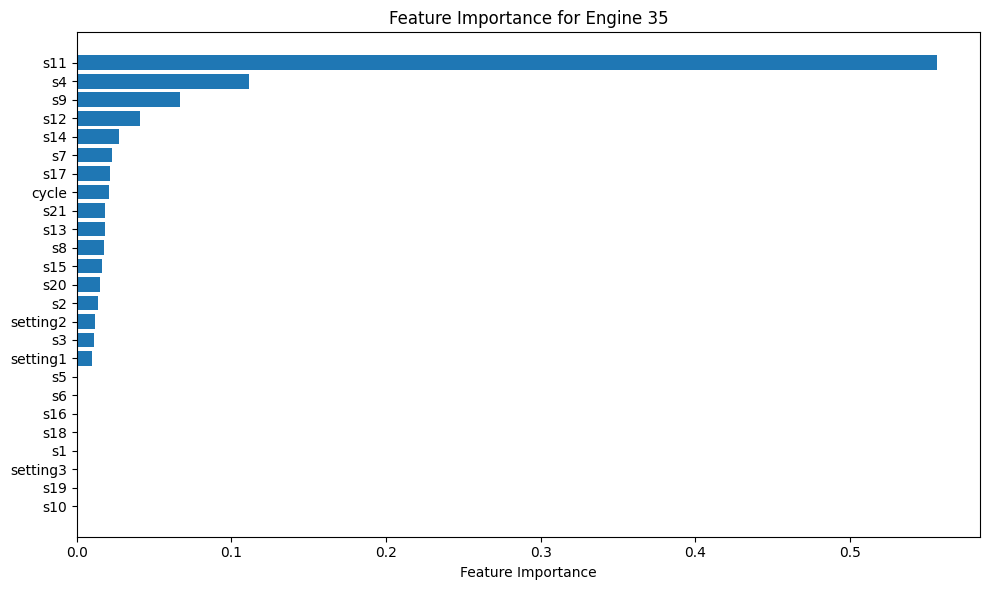

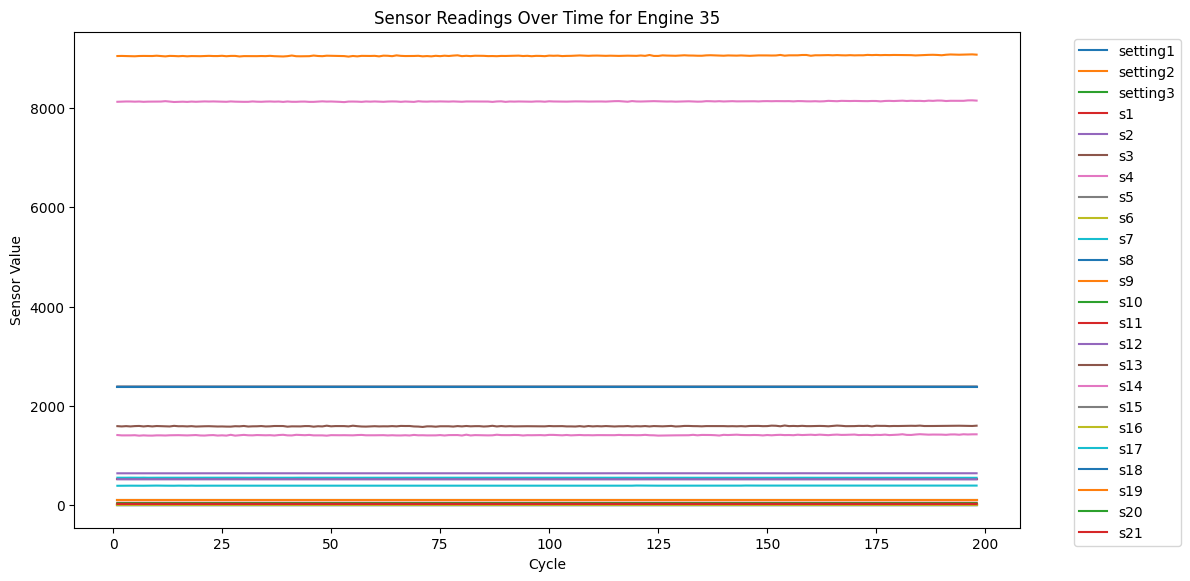



Engine 76: Probability of failure = 99.98%


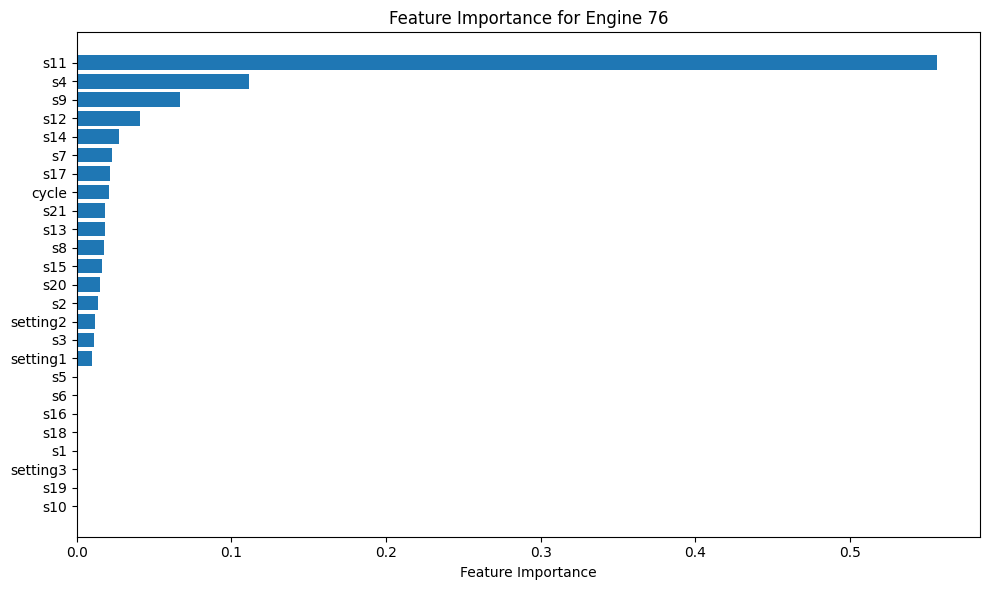

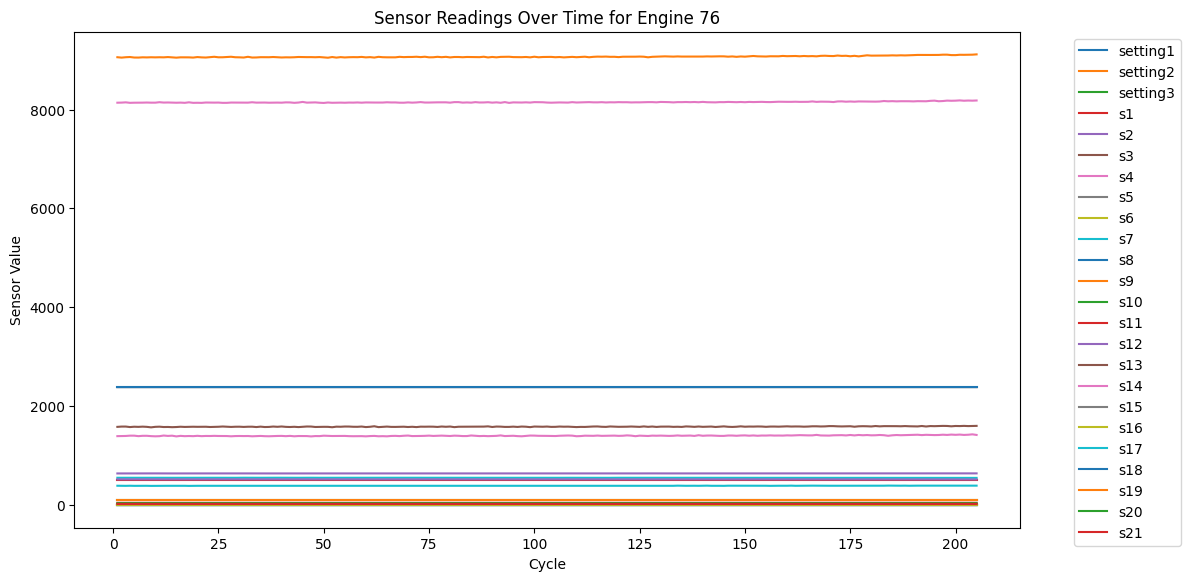



Engine 82: Probability of failure = 99.97%


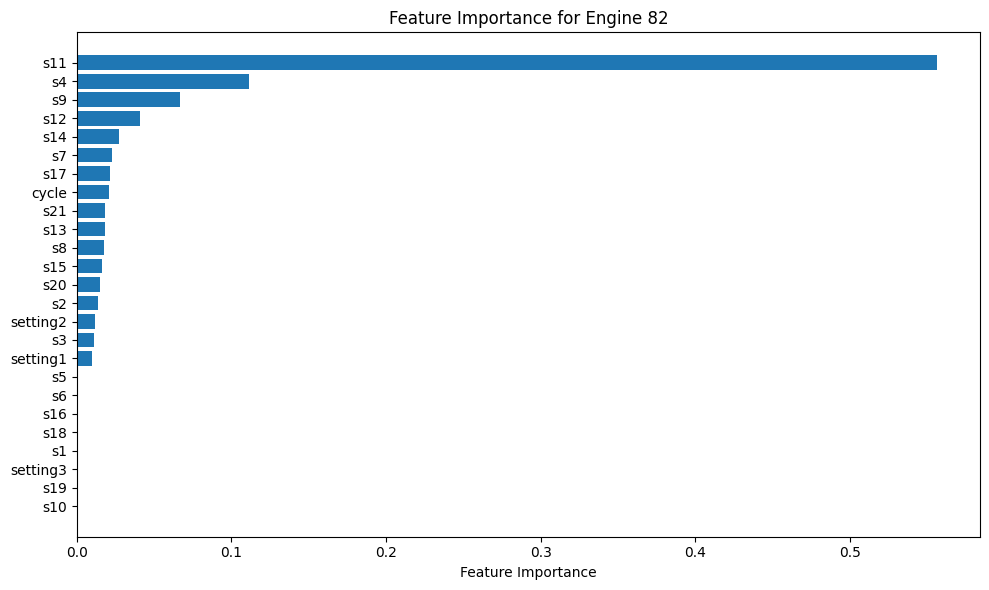

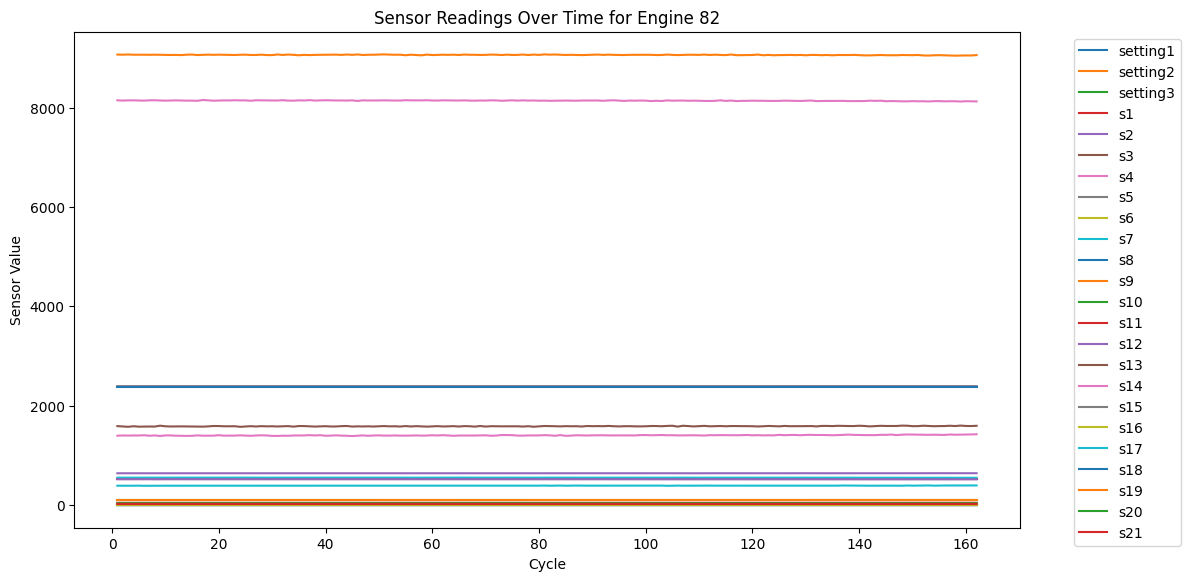



Engine 56: Probability of failure = 99.74%


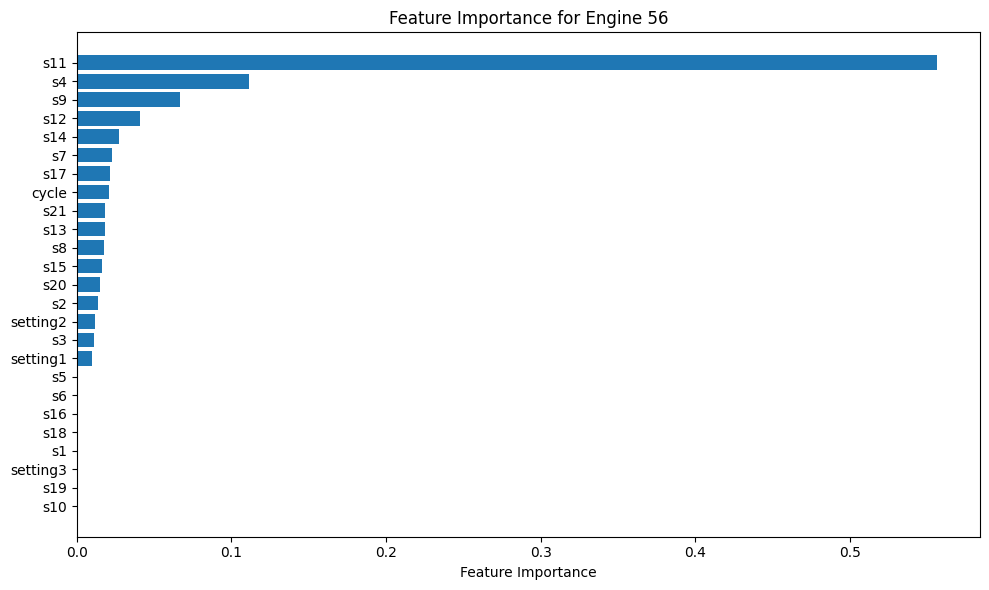

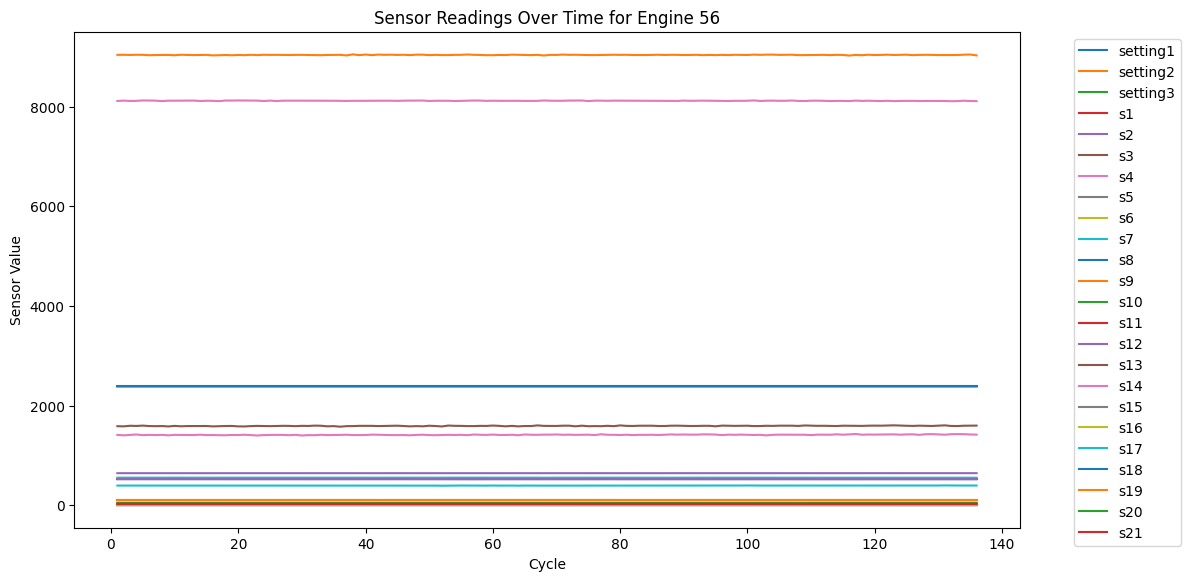



Engine 24: Probability of failure = 99.63%


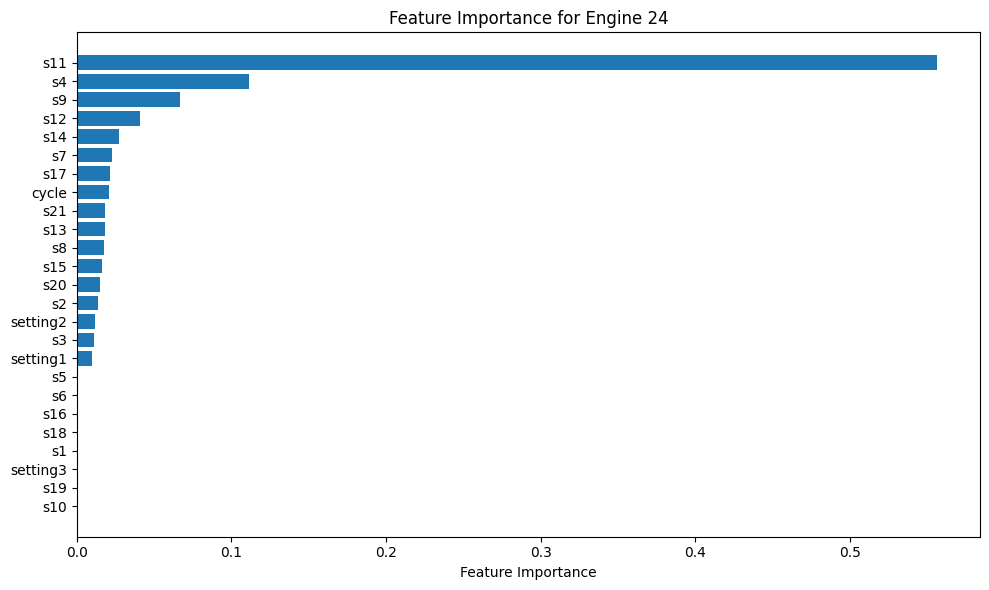

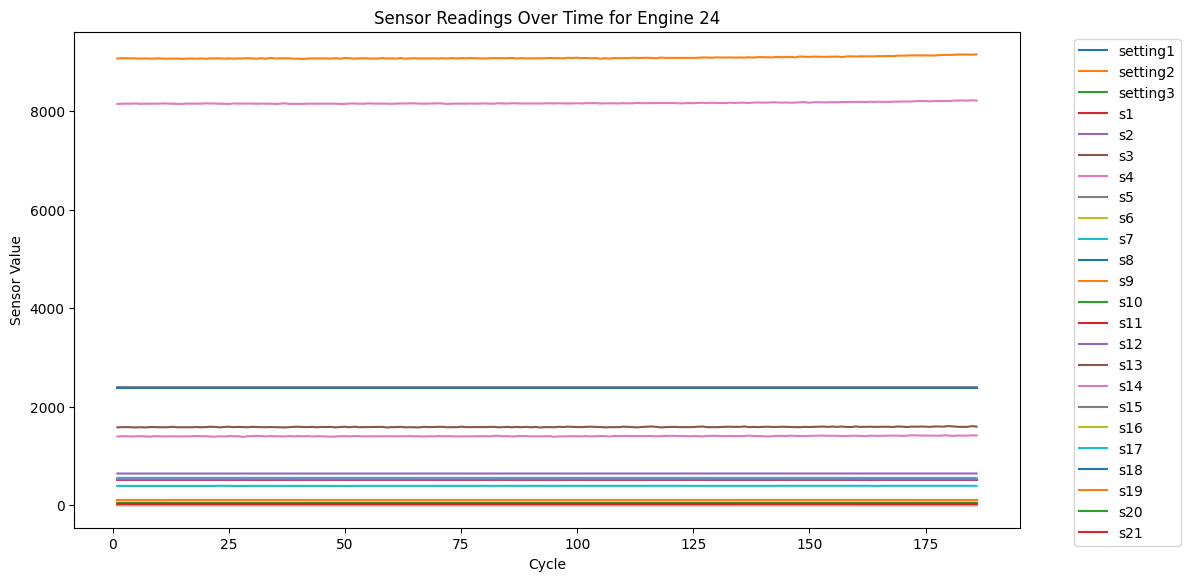



Engine 68: Probability of failure = 99.61%


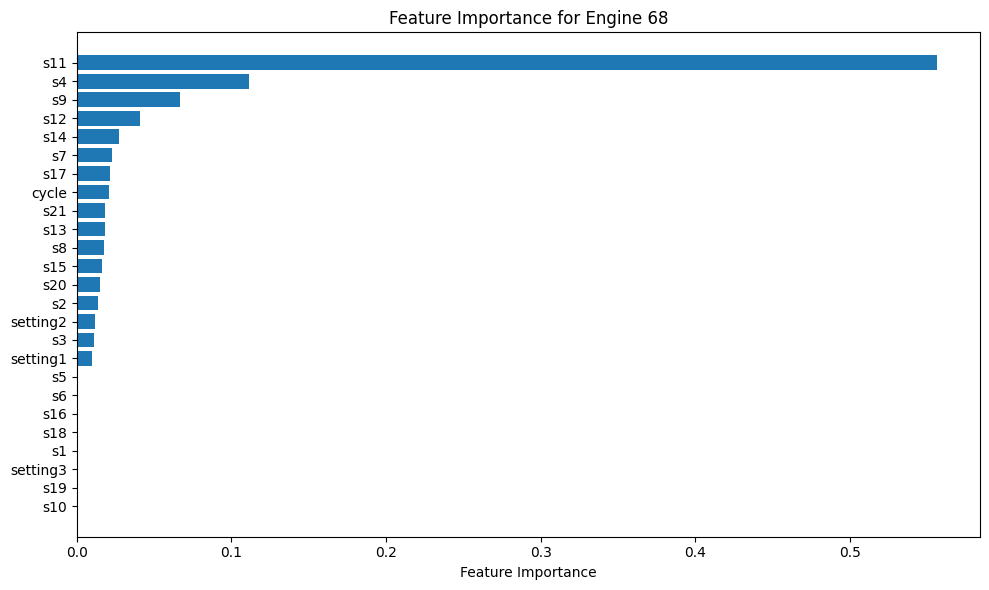

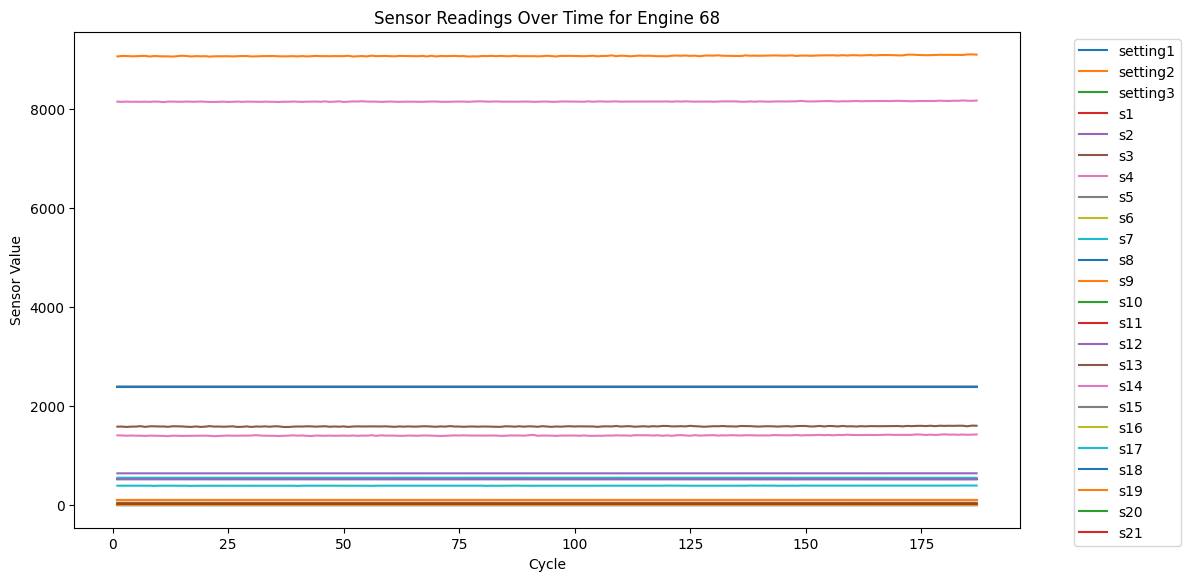



Engine 20: Probability of failure = 99.50%


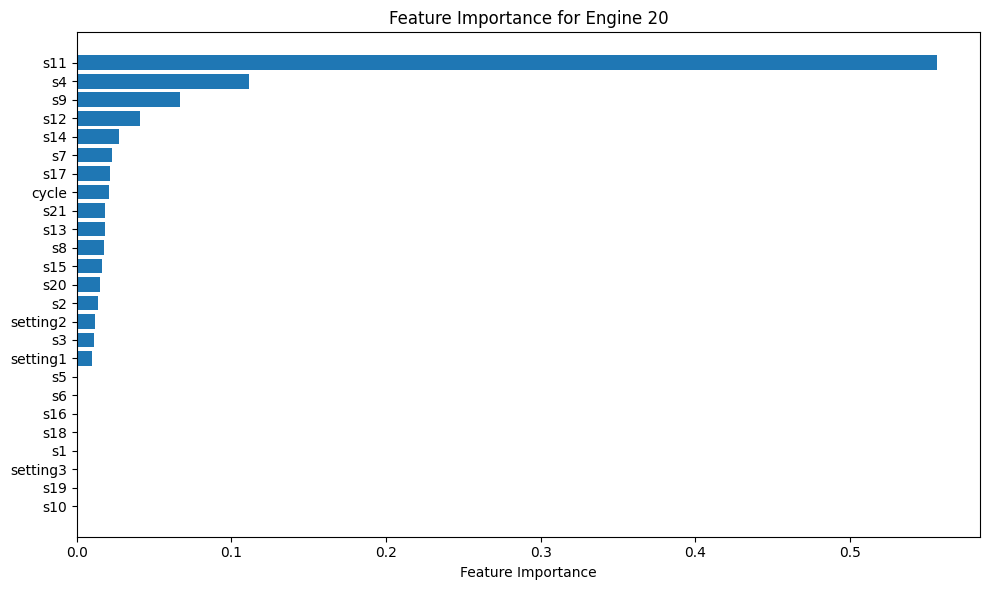

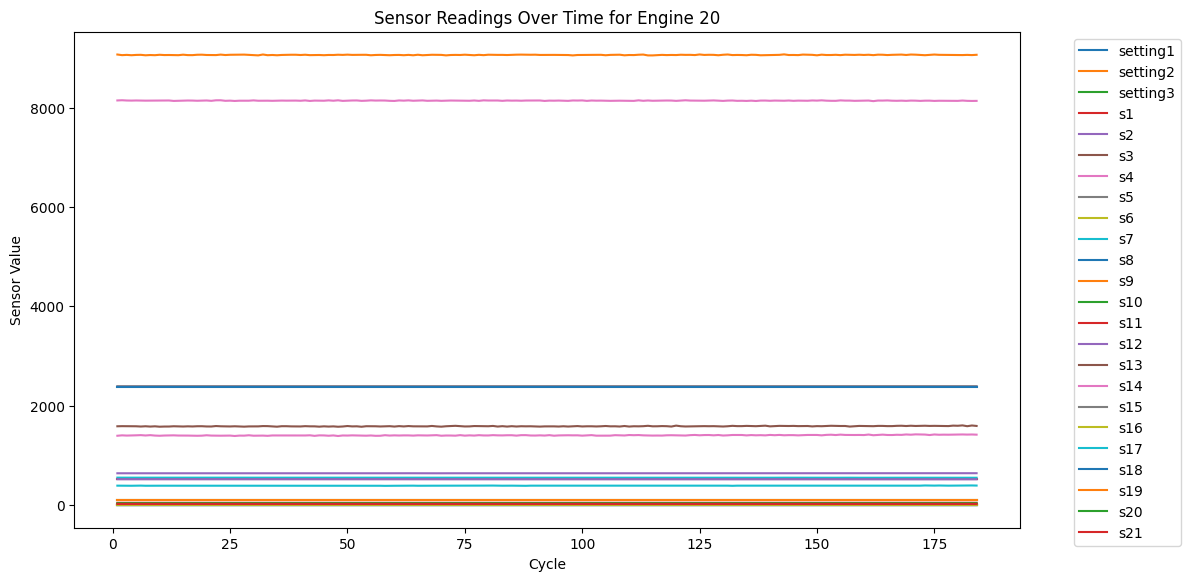



Engine 31: Probability of failure = 98.86%


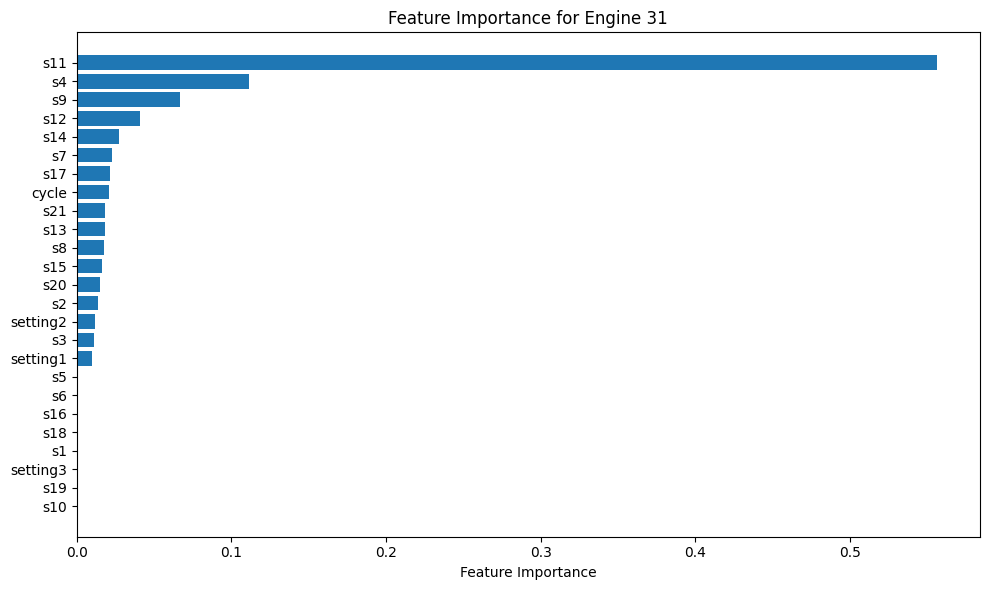

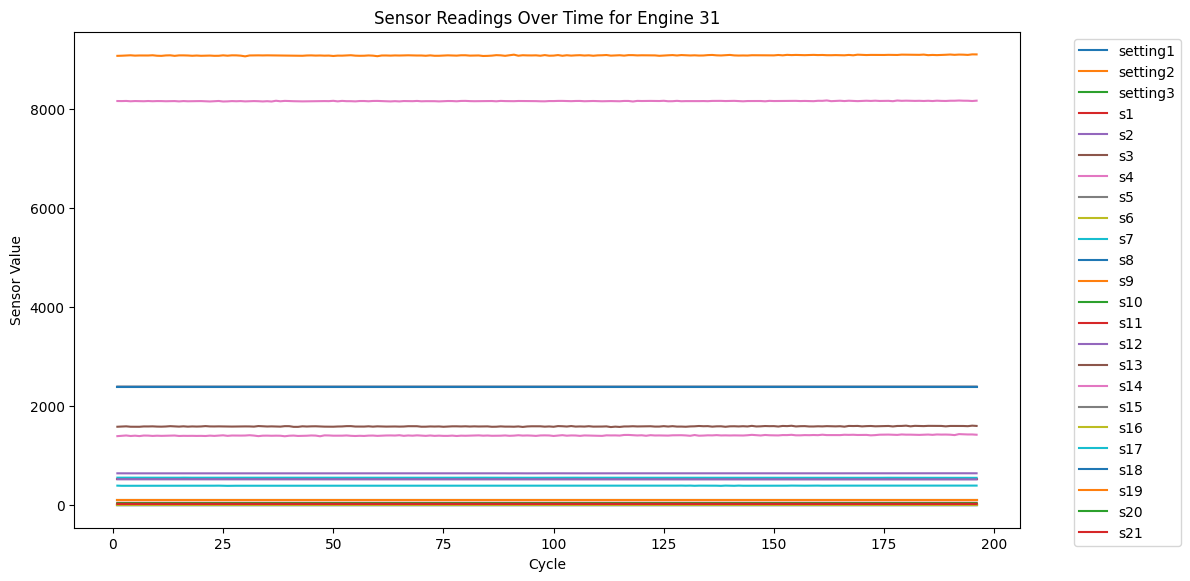



Engine 36: Probability of failure = 97.59%


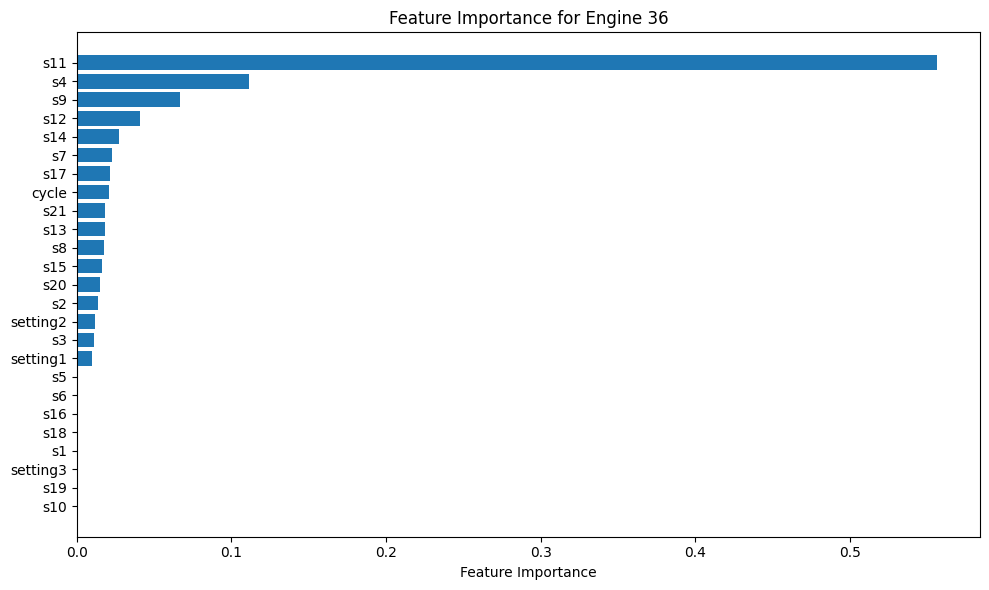

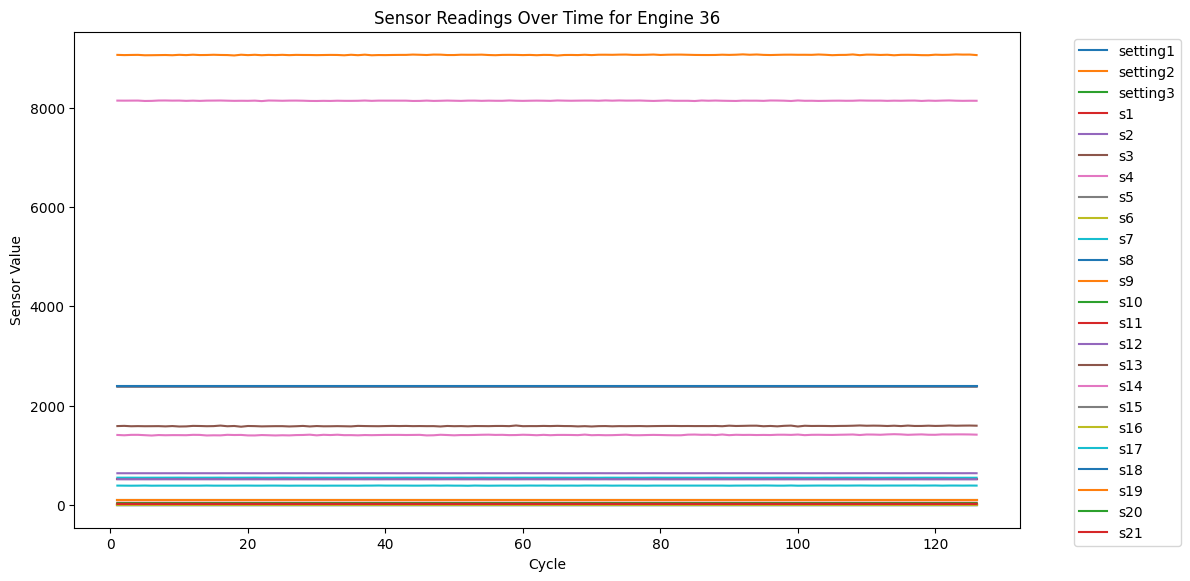



Engine 42: Probability of failure = 96.75%


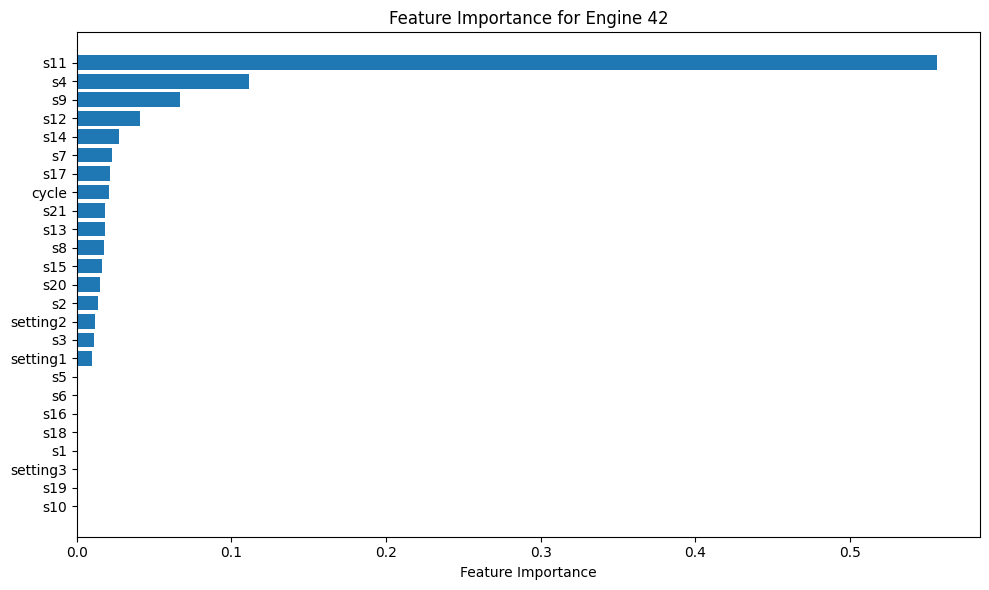

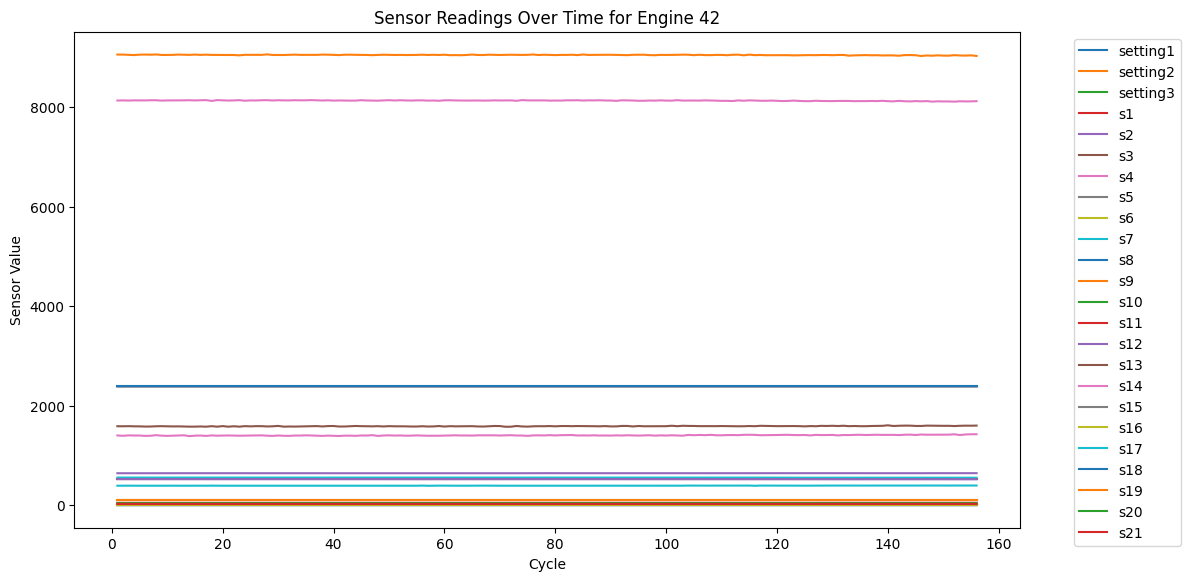



Engine 92: Probability of failure = 95.50%


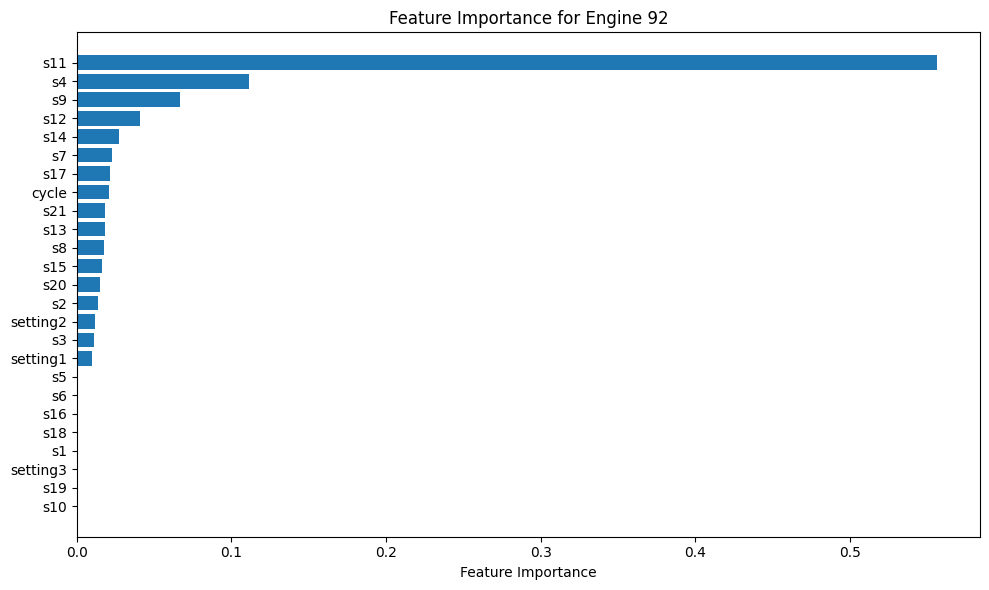

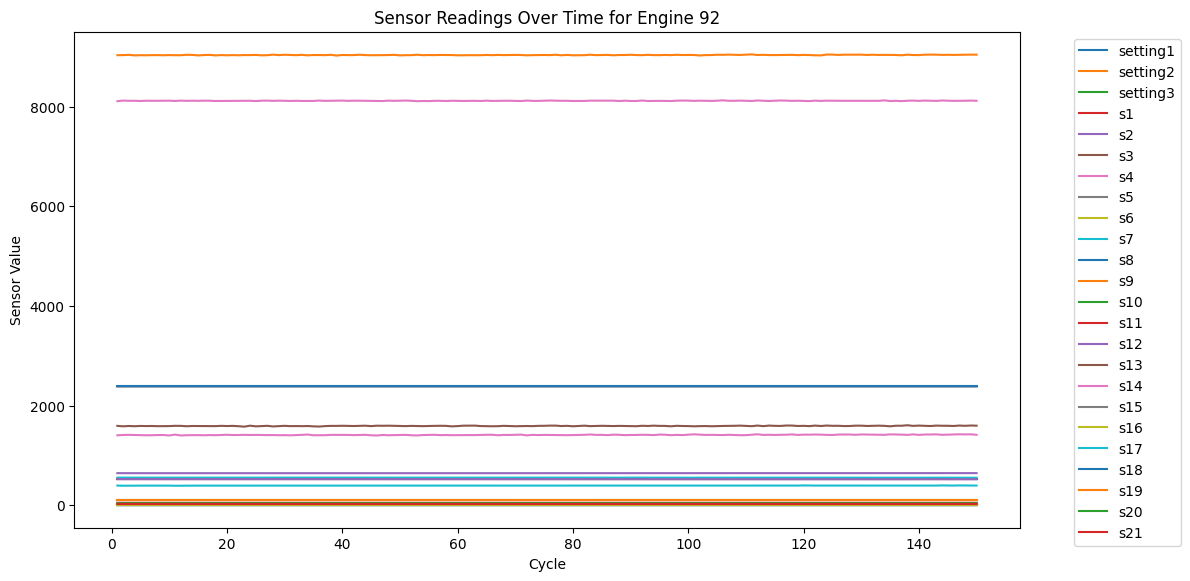



Engine 49: Probability of failure = 91.14%


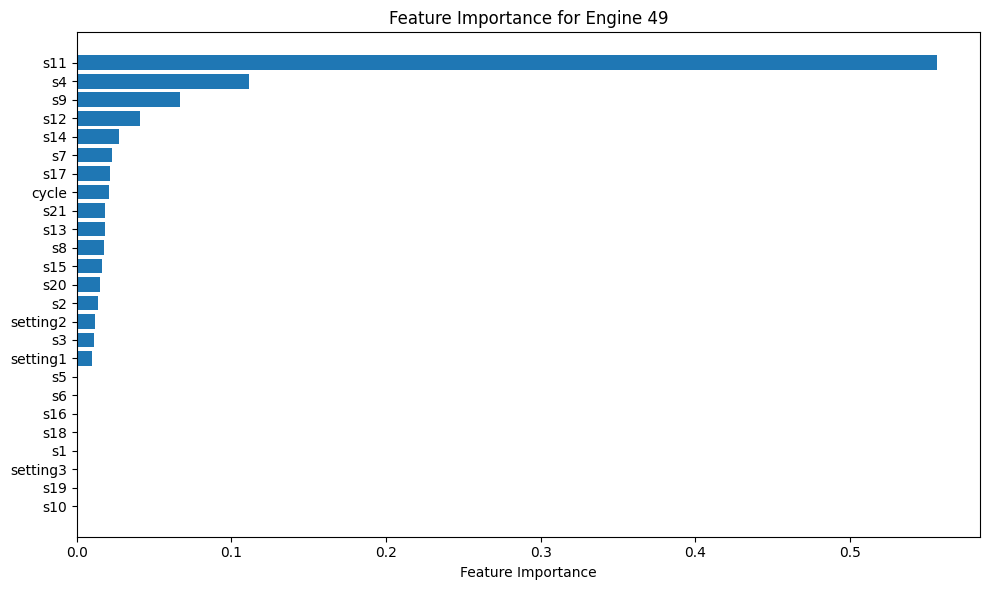

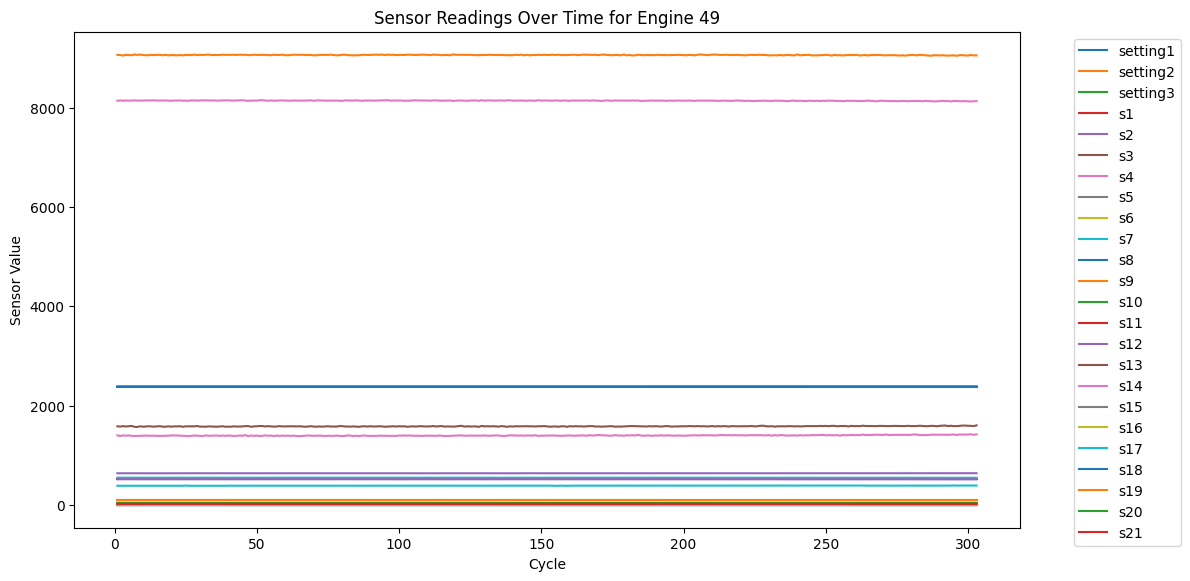



Engine 52: Probability of failure = 86.64%


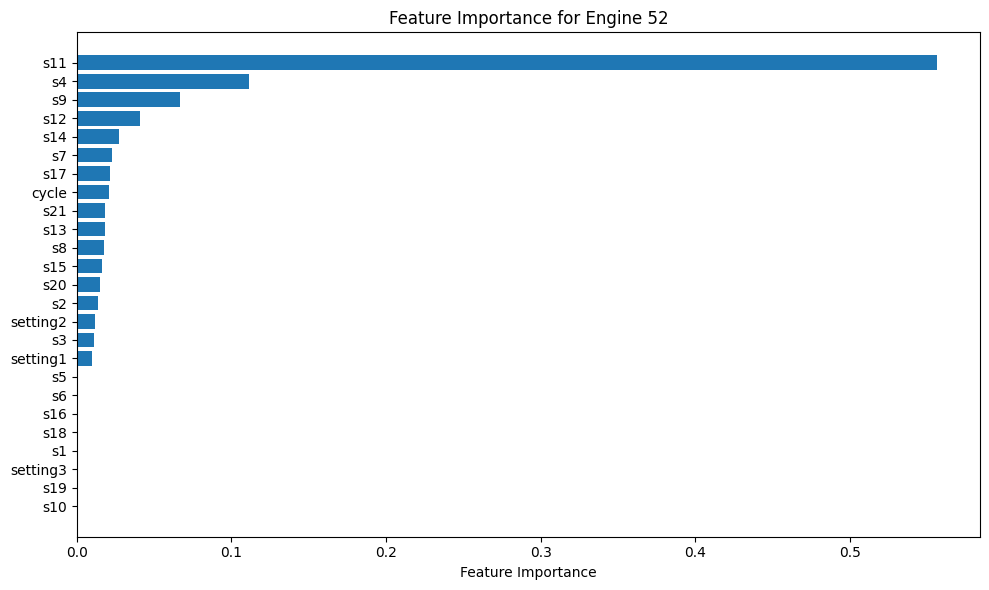

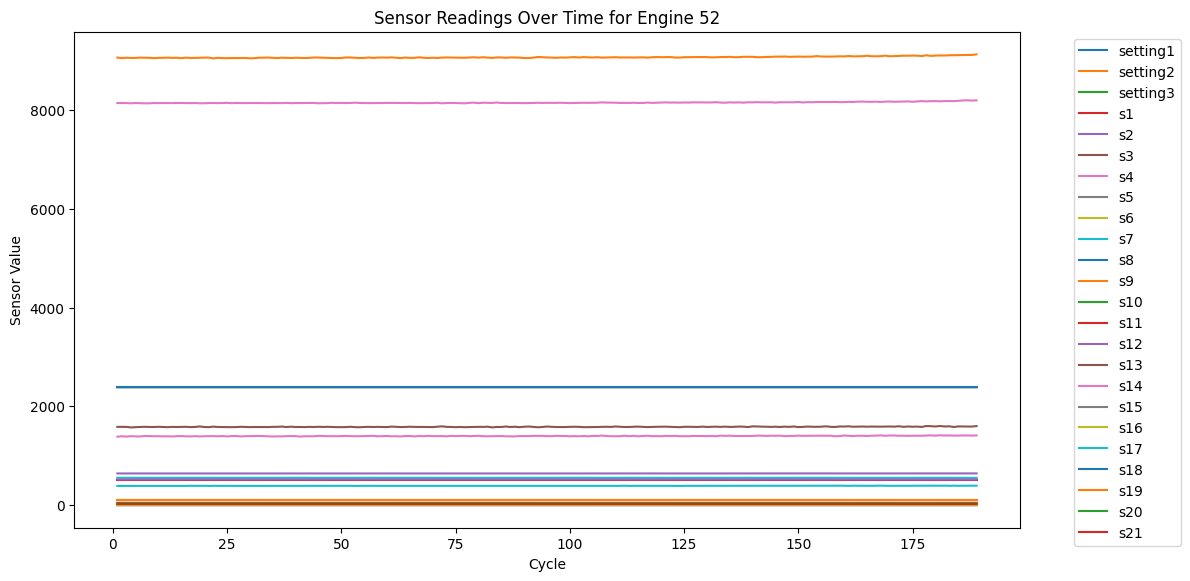



Engine 91: Probability of failure = 85.65%


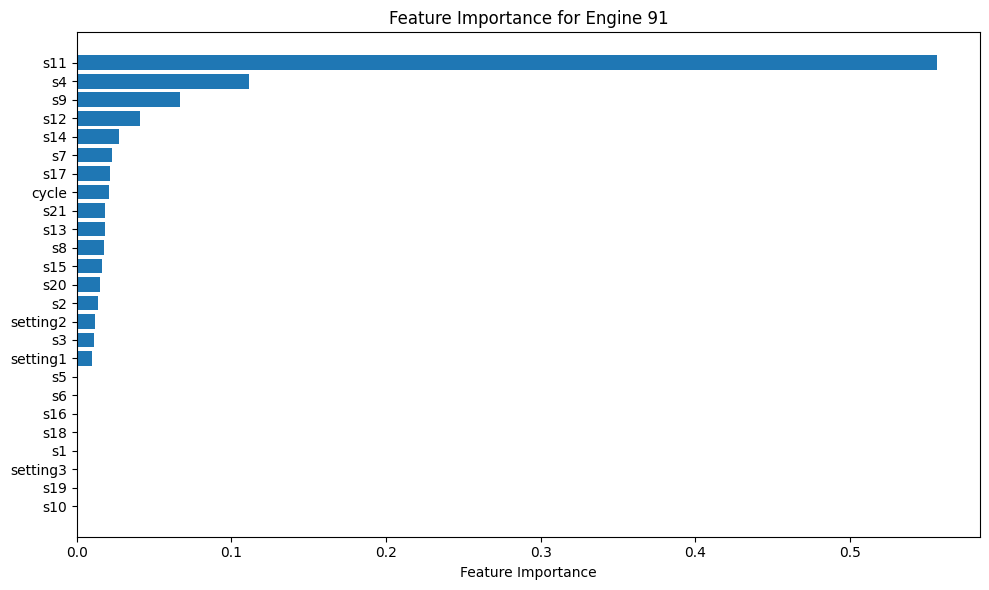

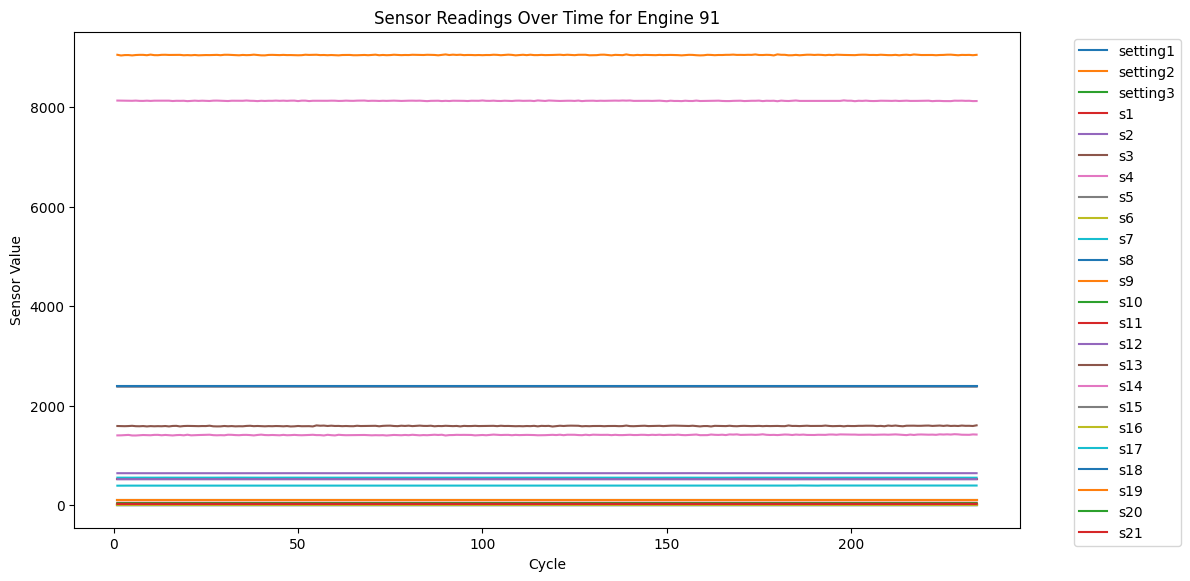



Engine 40: Probability of failure = 83.24%


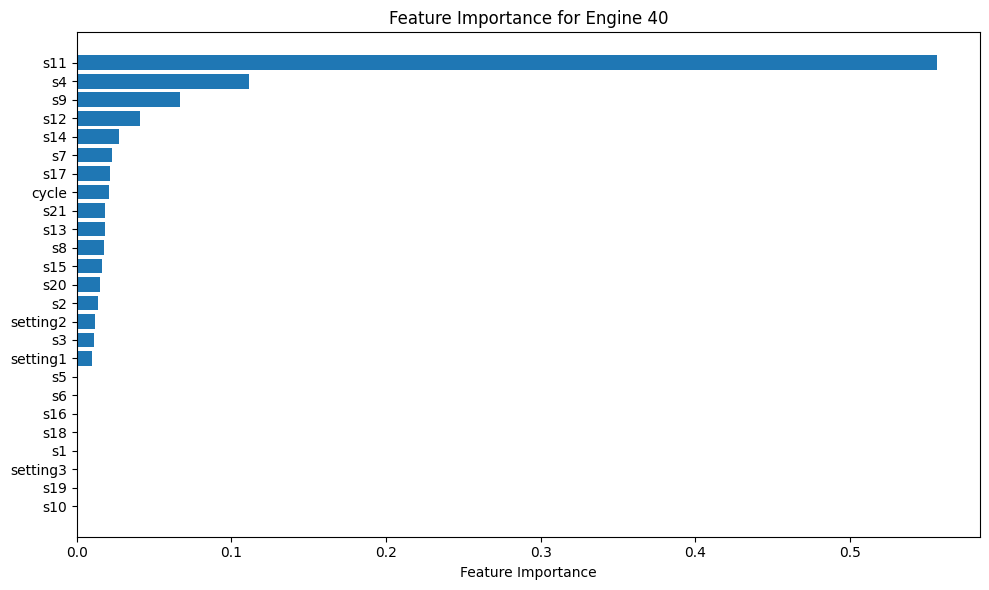

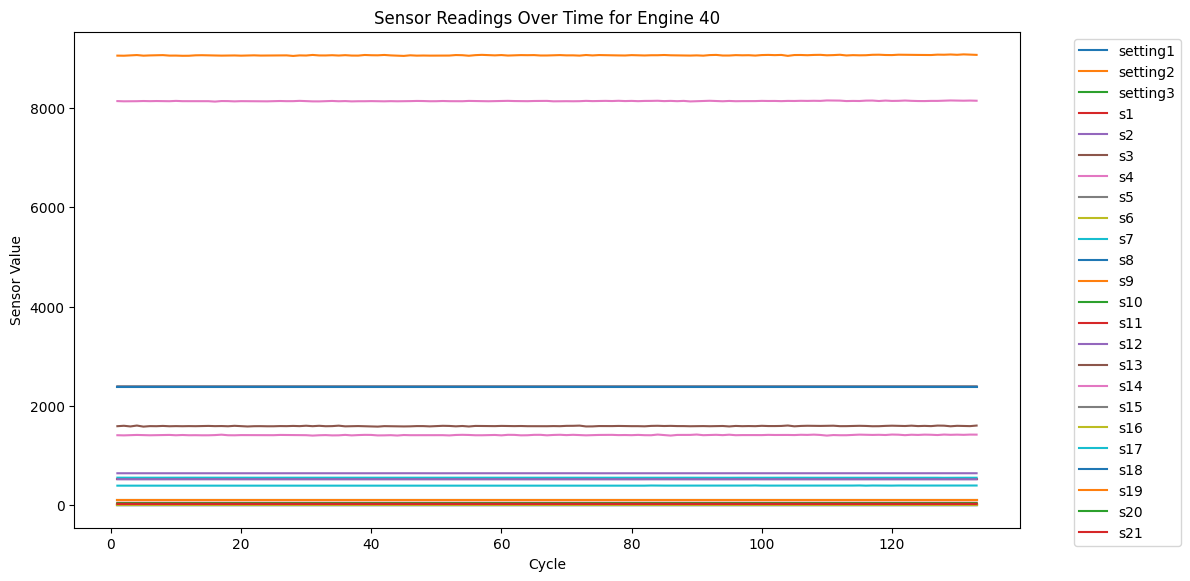



Engine 77: Probability of failure = 55.08%


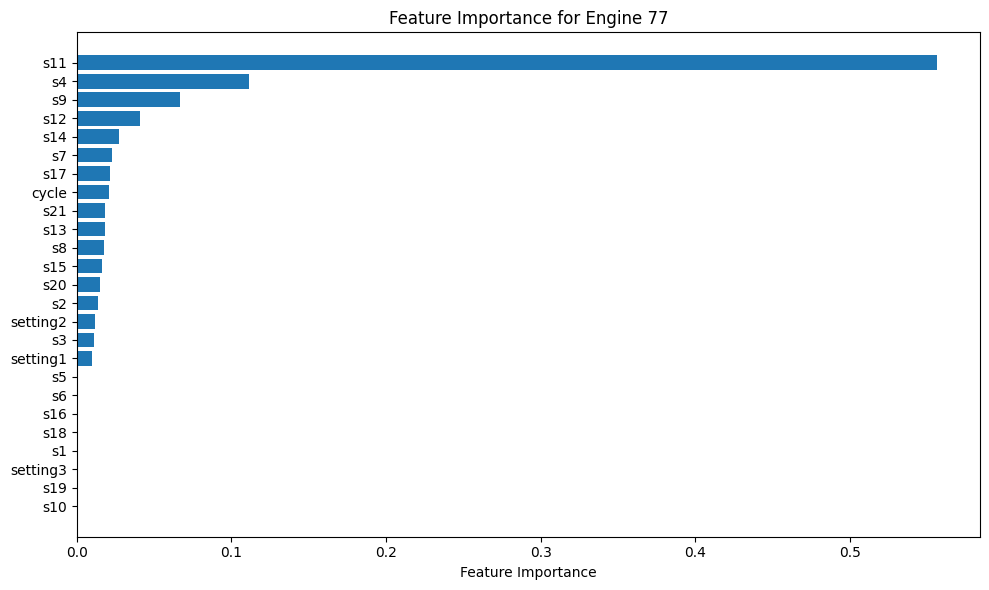

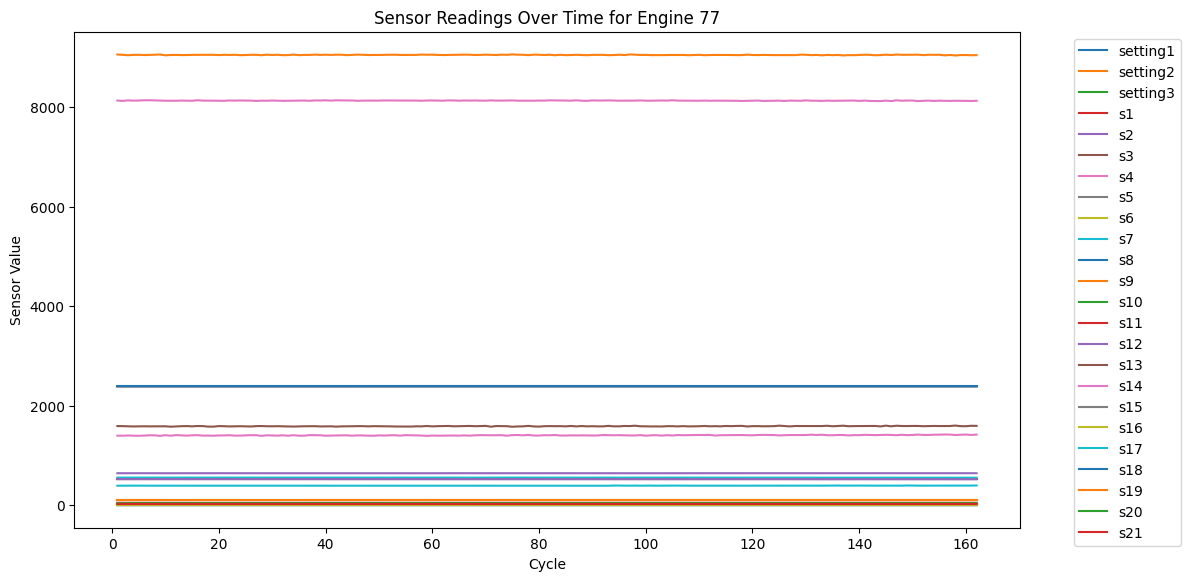

In [64]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_and_preprocess_data():
    train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
    test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)

    cols = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, train_df.shape[1] - 4)]
    train_df.columns = cols
    test_df.columns = cols

    train_df.dropna(axis=1, inplace=True)
    test_df.dropna(axis=1, inplace=True)

    def add_rul_and_label(df):
        rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
        rul.columns = ['id', 'max']
        df = df.merge(rul, on=['id'], how='left')
        df['RUL'] = df['max'] - df['cycle']
        df.drop('max', axis=1, inplace=True)
        df['failure_within_w1'] = np.where(df['RUL'] <= 30, 1, 0)
        return df

    train_df = add_rul_and_label(train_df)

    features = [col for col in train_df.columns if col.startswith('s') or col.startswith('setting')] + ['cycle']
    X = train_df[features]
    y = train_df['failure_within_w1']

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

    return X_scaled, y, test_df, features, scaler

# Train XGBoost model
def train_xgboost_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model

# Prepare data and train model
X, y, test_df, features, scaler = load_and_preprocess_data()
model = train_xgboost_model(X, y)

# Function to predict and explain for engines requiring maintenance
def predict_and_explain_maintenance():
    maintenance_required = []
    for engine_id in test_df['id'].unique():
        engine_data = test_df[test_df['id'] == engine_id].sort_values('cycle')
        last_cycle_data = engine_data.iloc[-1]

        X_test = pd.DataFrame([last_cycle_data[features].values], columns=features)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

        probability = model.predict_proba(X_test_scaled)[0][1]

        if probability > 0.5:  # Adjust this threshold as needed
            maintenance_required.append((engine_id, probability))

    maintenance_required.sort(key=lambda x: x[1], reverse=True)

    print(f"Engines requiring maintenance within 30 cycles:")
    for engine_id, probability in maintenance_required:
        print(f"Engine {engine_id}: Probability of failure = {probability:.2%}")

        # Feature importance plot
        plt.figure(figsize=(10, 6))
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
        plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
        plt.xlabel("Feature Importance")
        plt.title(f"Feature Importance for Engine {engine_id}")
        plt.tight_layout()
        plt.show()

        # Sensor readings plot
        plt.figure(figsize=(12, 6))
        engine_data = test_df[test_df['id'] == engine_id].sort_values('cycle')
        sensor_cols = [col for col in features if col.startswith('s')]
        for col in sensor_cols:
            plt.plot(engine_data['cycle'], engine_data[col], label=col)
        plt.xlabel("Cycle")
        plt.ylabel("Sensor Value")
        plt.title(f"Sensor Readings Over Time for Engine {engine_id}")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        print("\n" + "="*50 + "\n")

# Run the analysis
predict_and_explain_maintenance()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:03:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


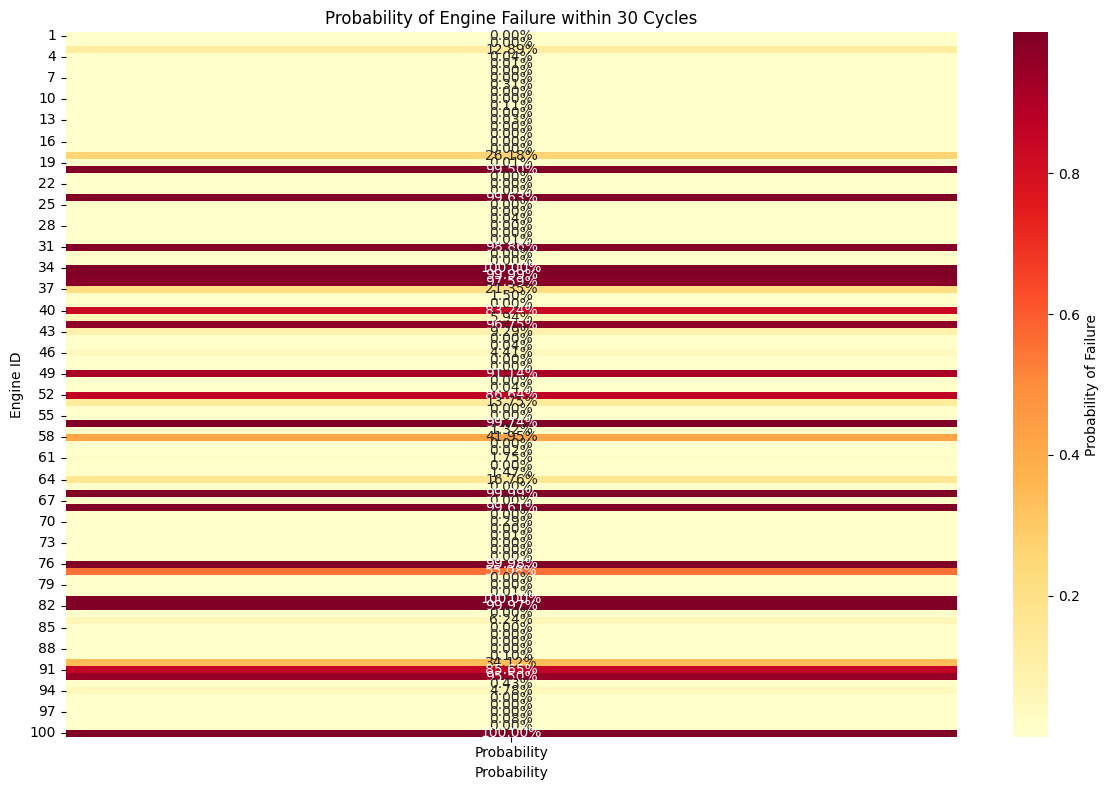


Engines with high risk of failure (>50% probability):
Engine 81: 100.00%
Engine 100: 100.00%
Engine 34: 100.00%
Engine 66: 99.99%
Engine 35: 99.99%
Engine 76: 99.98%
Engine 82: 99.97%
Engine 56: 99.74%
Engine 24: 99.63%
Engine 68: 99.61%
Engine 20: 99.50%
Engine 31: 98.86%
Engine 36: 97.59%
Engine 42: 96.75%
Engine 92: 95.50%
Engine 49: 91.14%
Engine 52: 86.64%
Engine 91: 85.65%
Engine 40: 83.24%
Engine 77: 55.08%


In [65]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data (same as before)
def load_and_preprocess_data():
    train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
    test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)

    cols = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, train_df.shape[1] - 4)]
    train_df.columns = cols
    test_df.columns = cols

    train_df.dropna(axis=1, inplace=True)
    test_df.dropna(axis=1, inplace=True)

    def add_rul_and_label(df):
        rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
        rul.columns = ['id', 'max']
        df = df.merge(rul, on=['id'], how='left')
        df['RUL'] = df['max'] - df['cycle']
        df.drop('max', axis=1, inplace=True)
        df['failure_within_w1'] = np.where(df['RUL'] <= 30, 1, 0)
        return df

    train_df = add_rul_and_label(train_df)

    features = [col for col in train_df.columns if col.startswith('s') or col.startswith('setting')] + ['cycle']
    X = train_df[features]
    y = train_df['failure_within_w1']

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

    return X_scaled, y, test_df, features, scaler

# Train XGBoost model (same as before)
def train_xgboost_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model

# Prepare data and train model
X, y, test_df, features, scaler = load_and_preprocess_data()
model = train_xgboost_model(X, y)

# Function to calculate failure probabilities for all engines
def calculate_failure_probabilities():
    probabilities = {}
    for engine_id in test_df['id'].unique():
        engine_data = test_df[test_df['id'] == engine_id].sort_values('cycle')
        last_cycle_data = engine_data.iloc[-1]

        X_test = pd.DataFrame([last_cycle_data[features].values], columns=features)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

        probability = model.predict_proba(X_test_scaled)[0][1]
        probabilities[engine_id] = probability

    return probabilities

# Create heatmap of failure probabilities
def create_failure_probability_heatmap(probabilities):
    # Convert probabilities dict to a DataFrame
    prob_df = pd.DataFrame.from_dict(probabilities, orient='index', columns=['Probability'])
    prob_df.reset_index(inplace=True)
    prob_df.columns = ['Engine', 'Probability']

    # Create a pivot table for the heatmap
    heatmap_data = prob_df.pivot_table(values='Probability', index=['Engine'], aggfunc='first')

    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.2%', cbar_kws={'label': 'Probability of Failure'})
    plt.title('Probability of Engine Failure within 30 Cycles')
    plt.xlabel('Probability')
    plt.ylabel('Engine ID')
    plt.tight_layout()
    plt.show()

# Run the analysis and create the heatmap
probabilities = calculate_failure_probabilities()
create_failure_probability_heatmap(probabilities)

# Print engines with high failure probability (e.g., > 50%)
high_risk_engines = {k: v for k, v in probabilities.items() if v > 0.5}
if high_risk_engines:
    print("\nEngines with high risk of failure (>50% probability):")
    for engine, prob in sorted(high_risk_engines.items(), key=lambda x: x[1], reverse=True):
        print(f"Engine {engine}: {prob:.2%}")
else:
    print("\nNo engines with failure probability >50% found.")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:03:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


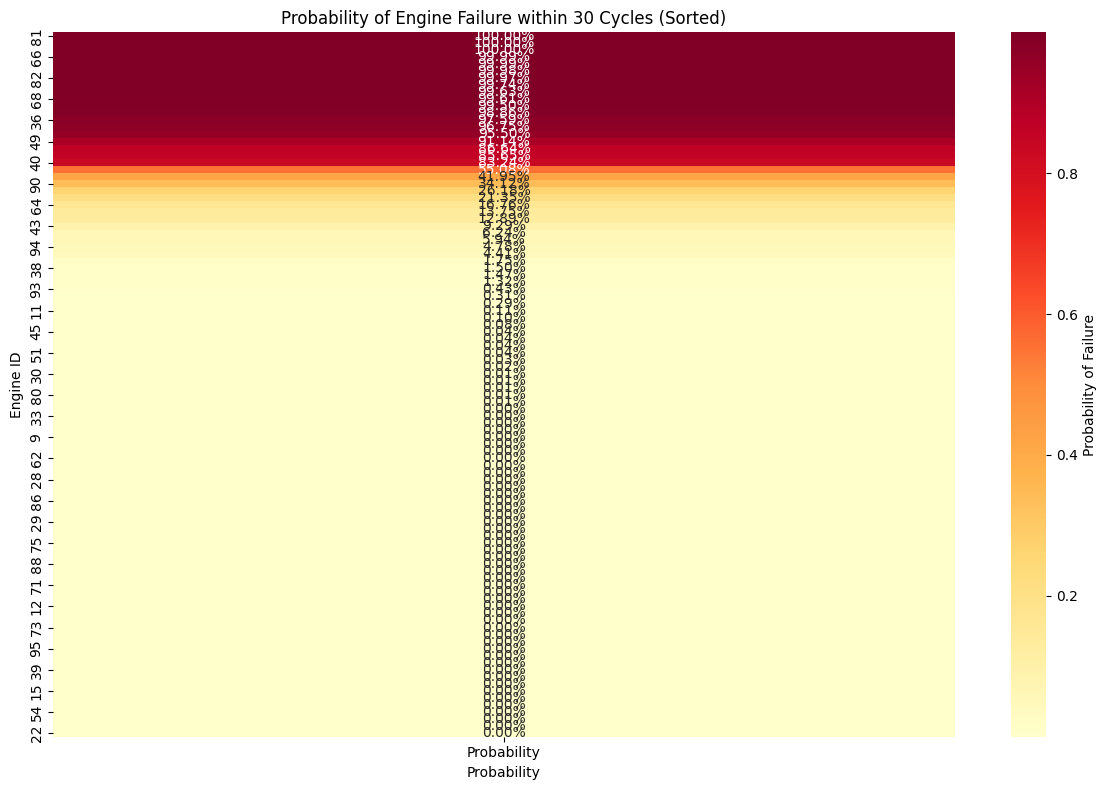


Engines with high risk of failure (>10% probability):
Engine 81.0: 100.00%
Engine 100.0: 100.00%
Engine 34.0: 100.00%
Engine 66.0: 99.99%
Engine 35.0: 99.99%
Engine 76.0: 99.98%
Engine 82.0: 99.97%
Engine 56.0: 99.74%
Engine 24.0: 99.63%
Engine 68.0: 99.61%
Engine 20.0: 99.50%
Engine 31.0: 98.86%
Engine 36.0: 97.59%
Engine 42.0: 96.75%
Engine 92.0: 95.50%
Engine 49.0: 91.14%
Engine 52.0: 86.64%
Engine 91.0: 85.65%
Engine 40.0: 83.24%
Engine 77.0: 55.08%
Engine 58.0: 41.95%
Engine 90.0: 34.12%
Engine 18.0: 26.18%
Engine 37.0: 21.35%
Engine 64.0: 16.76%
Engine 53.0: 13.75%
Engine 3.0: 12.89%

Summary Statistics:
Total number of engines: 100
Average failure probability: 20.94%
Median failure probability: 0.01%
Maximum failure probability: 100.00%
Minimum failure probability: 0.00%


In [66]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data (same as before)
def load_and_preprocess_data():
    train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
    test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)

    cols = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, train_df.shape[1] - 4)]
    train_df.columns = cols
    test_df.columns = cols

    train_df.dropna(axis=1, inplace=True)
    test_df.dropna(axis=1, inplace=True)

    def add_rul_and_label(df):
        rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
        rul.columns = ['id', 'max']
        df = df.merge(rul, on=['id'], how='left')
        df['RUL'] = df['max'] - df['cycle']
        df.drop('max', axis=1, inplace=True)
        df['failure_within_w1'] = np.where(df['RUL'] <= 30, 1, 0)
        return df

    train_df = add_rul_and_label(train_df)

    features = [col for col in train_df.columns if col.startswith('s') or col.startswith('setting')] + ['cycle']
    X = train_df[features]
    y = train_df['failure_within_w1']

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

    return X_scaled, y, test_df, features, scaler

# Train XGBoost model (same as before)
def train_xgboost_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model

# Prepare data and train model
X, y, test_df, features, scaler = load_and_preprocess_data()
model = train_xgboost_model(X, y)

# Function to calculate failure probabilities for all engines
def calculate_failure_probabilities():
    probabilities = {}
    for engine_id in test_df['id'].unique():
        engine_data = test_df[test_df['id'] == engine_id].sort_values('cycle')
        last_cycle_data = engine_data.iloc[-1]

        X_test = pd.DataFrame([last_cycle_data[features].values], columns=features)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

        probability = model.predict_proba(X_test_scaled)[0][1]
        probabilities[engine_id] = probability

    return probabilities

# Create heatmap of failure probabilities, sorted from highest to lowest
def create_sorted_failure_probability_heatmap(probabilities):
    # Convert probabilities dict to a DataFrame
    prob_df = pd.DataFrame.from_dict(probabilities, orient='index', columns=['Probability'])
    prob_df.reset_index(inplace=True)
    prob_df.columns = ['Engine', 'Probability']

    # Sort the DataFrame by probability in descending order
    prob_df = prob_df.sort_values('Probability', ascending=False)

    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(prob_df.set_index('Engine'), annot=True, cmap='YlOrRd', fmt='.2%', cbar_kws={'label': 'Probability of Failure'})
    plt.title('Probability of Engine Failure within 30 Cycles (Sorted)')
    plt.xlabel('Probability')
    plt.ylabel('Engine ID')
    plt.tight_layout()
    plt.show()

    return prob_df

# Run the analysis and create the sorted heatmap
probabilities = calculate_failure_probabilities()
sorted_prob_df = create_sorted_failure_probability_heatmap(probabilities)

# Print engines with high failure probability (e.g., > 10%)
high_risk_threshold = 0.10  # 10%
high_risk_engines = sorted_prob_df[sorted_prob_df['Probability'] > high_risk_threshold]
if not high_risk_engines.empty:
    print(f"\nEngines with high risk of failure (>{high_risk_threshold:.0%} probability):")
    for _, row in high_risk_engines.iterrows():
        print(f"Engine {row['Engine']}: {row['Probability']:.2%}")
else:
    print(f"\nNo engines with failure probability >{high_risk_threshold:.0%} found.")

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total number of engines: {len(probabilities)}")
print(f"Average failure probability: {sorted_prob_df['Probability'].mean():.2%}")
print(f"Median failure probability: {sorted_prob_df['Probability'].median():.2%}")
print(f"Maximum failure probability: {sorted_prob_df['Probability'].max():.2%}")
print(f"Minimum failure probability: {sorted_prob_df['Probability'].min():.2%}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:03:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


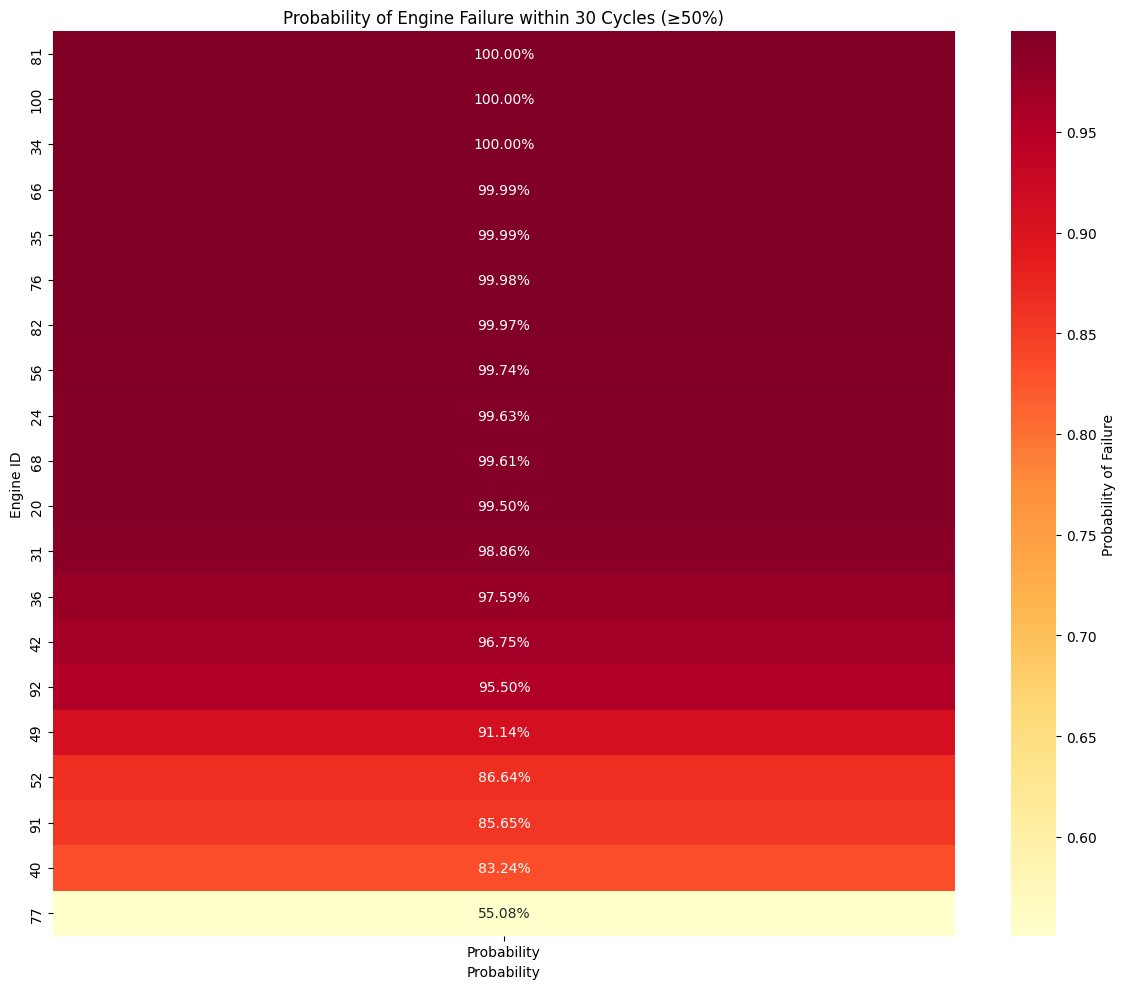


Engines with high risk of failure (≥50% probability):
Engine 81.0: 100.00%
Engine 100.0: 100.00%
Engine 34.0: 100.00%
Engine 66.0: 99.99%
Engine 35.0: 99.99%
Engine 76.0: 99.98%
Engine 82.0: 99.97%
Engine 56.0: 99.74%
Engine 24.0: 99.63%
Engine 68.0: 99.61%
Engine 20.0: 99.50%
Engine 31.0: 98.86%
Engine 36.0: 97.59%
Engine 42.0: 96.75%
Engine 92.0: 95.50%
Engine 49.0: 91.14%
Engine 52.0: 86.64%
Engine 91.0: 85.65%
Engine 40.0: 83.24%
Engine 77.0: 55.08%

Summary Statistics for All Engines:
Total number of engines: 100
Number of high-risk engines (≥50%): 20
Average failure probability: 20.94%
Median failure probability: 0.01%
Maximum failure probability: 100.00%
Minimum failure probability: 0.00%


In [67]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data (same as before)
def load_and_preprocess_data():
    train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
    test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)

    cols = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, train_df.shape[1] - 4)]
    train_df.columns = cols
    test_df.columns = cols

    train_df.dropna(axis=1, inplace=True)
    test_df.dropna(axis=1, inplace=True)

    def add_rul_and_label(df):
        rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
        rul.columns = ['id', 'max']
        df = df.merge(rul, on=['id'], how='left')
        df['RUL'] = df['max'] - df['cycle']
        df.drop('max', axis=1, inplace=True)
        df['failure_within_w1'] = np.where(df['RUL'] <= 30, 1, 0)
        return df

    train_df = add_rul_and_label(train_df)

    features = [col for col in train_df.columns if col.startswith('s') or col.startswith('setting')] + ['cycle']
    X = train_df[features]
    y = train_df['failure_within_w1']

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

    return X_scaled, y, test_df, features, scaler

# Train XGBoost model (same as before)
def train_xgboost_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model

# Prepare data and train model
X, y, test_df, features, scaler = load_and_preprocess_data()
model = train_xgboost_model(X, y)

# Function to calculate failure probabilities for all engines
def calculate_failure_probabilities():
    probabilities = {}
    for engine_id in test_df['id'].unique():
        engine_data = test_df[test_df['id'] == engine_id].sort_values('cycle')
        last_cycle_data = engine_data.iloc[-1]

        X_test = pd.DataFrame([last_cycle_data[features].values], columns=features)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

        probability = model.predict_proba(X_test_scaled)[0][1]
        probabilities[engine_id] = probability

    return probabilities

# Create heatmap of failure probabilities for high-risk engines (≥50%)
def create_high_risk_failure_probability_heatmap(probabilities):
    # Convert probabilities dict to a DataFrame
    prob_df = pd.DataFrame.from_dict(probabilities, orient='index', columns=['Probability'])
    prob_df.reset_index(inplace=True)
    prob_df.columns = ['Engine', 'Probability']

    # Filter for high-risk engines (≥50% probability)
    high_risk_df = prob_df[prob_df['Probability'] >= 0.5].sort_values('Probability', ascending=False)

    if high_risk_df.empty:
        print("No engines with failure probability ≥50% found.")
        return high_risk_df

    # Create the heatmap
    plt.figure(figsize=(12, len(high_risk_df) * 0.5))  # Adjust figure height based on number of engines
    sns.heatmap(high_risk_df.set_index('Engine'), annot=True, cmap='YlOrRd', fmt='.2%', cbar_kws={'label': 'Probability of Failure'})
    plt.title('Probability of Engine Failure within 30 Cycles (≥50%)')
    plt.xlabel('Probability')
    plt.ylabel('Engine ID')
    plt.tight_layout()
    plt.show()

    return high_risk_df

# Run the analysis and create the heatmap for high-risk engines
probabilities = calculate_failure_probabilities()
high_risk_df = create_high_risk_failure_probability_heatmap(probabilities)

# Print high-risk engines
if not high_risk_df.empty:
    print("\nEngines with high risk of failure (≥50% probability):")
    for _, row in high_risk_df.iterrows():
        print(f"Engine {row['Engine']}: {row['Probability']:.2%}")
else:
    print("\nNo engines with failure probability ≥50% found.")

# Print summary statistics
print("\nSummary Statistics for All Engines:")
prob_series = pd.Series(probabilities.values())
print(f"Total number of engines: {len(probabilities)}")
print(f"Number of high-risk engines (≥50%): {len(high_risk_df)}")
print(f"Average failure probability: {prob_series.mean():.2%}")
print(f"Median failure probability: {prob_series.median():.2%}")
print(f"Maximum failure probability: {prob_series.max():.2%}")
print(f"Minimum failure probability: {prob_series.min():.2%}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:03:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


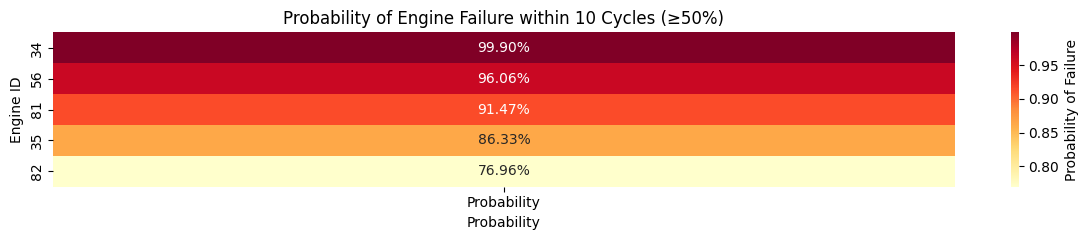


Engines with high risk of failure within 10 cycles (≥50% probability):
Engine 34.0: 99.90%
Engine 56.0: 96.06%
Engine 81.0: 91.47%
Engine 35.0: 86.33%
Engine 82.0: 76.96%

Summary Statistics for All Engines:
Total number of engines: 100
Number of high-risk engines (≥50%): 5
Average failure probability: 5.30%
Median failure probability: 0.00%
Maximum failure probability: 99.90%
Minimum failure probability: 0.00%

Top 10 Most Important Features:
   feature  importance
13     s11    0.563994
6       s4    0.080697
9       s7    0.043284
14     s12    0.041848
17     s15    0.032152
16     s14    0.029357
22     s20    0.028975
11      s9    0.028756
19     s17    0.027114
23     s21    0.020216


In [68]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_and_preprocess_data():
    train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
    test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)

    cols = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, train_df.shape[1] - 4)]
    train_df.columns = cols
    test_df.columns = cols

    train_df.dropna(axis=1, inplace=True)
    test_df.dropna(axis=1, inplace=True)

    def add_rul_and_label(df):
        rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
        rul.columns = ['id', 'max']
        df = df.merge(rul, on=['id'], how='left')
        df['RUL'] = df['max'] - df['cycle']
        df.drop('max', axis=1, inplace=True)
        # Change to 10 cycles
        df['failure_within_w1'] = np.where(df['RUL'] <= 10, 1, 0)
        return df

    train_df = add_rul_and_label(train_df)

    features = [col for col in train_df.columns if col.startswith('s') or col.startswith('setting')] + ['cycle']
    X = train_df[features]
    y = train_df['failure_within_w1']

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

    return X_scaled, y, test_df, features, scaler

# Train XGBoost model
def train_xgboost_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model

# Prepare data and train model
X, y, test_df, features, scaler = load_and_preprocess_data()
model = train_xgboost_model(X, y)

# Function to calculate failure probabilities for all engines
def calculate_failure_probabilities():
    probabilities = {}
    for engine_id in test_df['id'].unique():
        engine_data = test_df[test_df['id'] == engine_id].sort_values('cycle')
        last_cycle_data = engine_data.iloc[-1]

        X_test = pd.DataFrame([last_cycle_data[features].values], columns=features)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

        probability = model.predict_proba(X_test_scaled)[0][1]
        probabilities[engine_id] = probability

    return probabilities

# Create heatmap of failure probabilities for high-risk engines (≥50%)
def create_high_risk_failure_probability_heatmap(probabilities):
    prob_df = pd.DataFrame.from_dict(probabilities, orient='index', columns=['Probability'])
    prob_df.reset_index(inplace=True)
    prob_df.columns = ['Engine', 'Probability']

    high_risk_df = prob_df[prob_df['Probability'] >= 0.5].sort_values('Probability', ascending=False)

    if high_risk_df.empty:
        print("No engines with failure probability ≥50% found.")
        return high_risk_df

    plt.figure(figsize=(12, len(high_risk_df) * 0.5))
    sns.heatmap(high_risk_df.set_index('Engine'), annot=True, cmap='YlOrRd', fmt='.2%', cbar_kws={'label': 'Probability of Failure'})
    plt.title('Probability of Engine Failure within 10 Cycles (≥50%)')
    plt.xlabel('Probability')
    plt.ylabel('Engine ID')
    plt.tight_layout()
    plt.show()

    return high_risk_df

# Run the analysis and create the heatmap for high-risk engines
probabilities = calculate_failure_probabilities()
high_risk_df = create_high_risk_failure_probability_heatmap(probabilities)

# Print high-risk engines
if not high_risk_df.empty:
    print("\nEngines with high risk of failure within 10 cycles (≥50% probability):")
    for _, row in high_risk_df.iterrows():
        print(f"Engine {row['Engine']}: {row['Probability']:.2%}")
else:
    print("\nNo engines with failure probability ≥50% within 10 cycles found.")

# Print summary statistics
print("\nSummary Statistics for All Engines:")
prob_series = pd.Series(probabilities.values())
print(f"Total number of engines: {len(probabilities)}")
print(f"Number of high-risk engines (≥50%): {len(high_risk_df)}")
print(f"Average failure probability: {prob_series.mean():.2%}")
print(f"Median failure probability: {prob_series.median():.2%}")
print(f"Maximum failure probability: {prob_series.max():.2%}")
print(f"Minimum failure probability: {prob_series.min():.2%}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

In [69]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load and preprocess data
def load_and_preprocess_data():
    train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
    test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)

    cols = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, train_df.shape[1] - 4)]
    train_df.columns = cols
    test_df.columns = cols

    train_df.dropna(axis=1, inplace=True)
    test_df.dropna(axis=1, inplace=True)

    def add_rul(df):
        rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
        rul.columns = ['id', 'max']
        df = df.merge(rul, on=['id'], how='left')
        df['RUL'] = df['max'] - df['cycle']
        df.drop('max', axis=1, inplace=True)
        return df

    train_df = add_rul(train_df)

    features = [col for col in train_df.columns if col.startswith('s') or col.startswith('setting')] + ['cycle']
    X = train_df[features]
    y = train_df['RUL']

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

    return X_scaled, y, test_df, features, scaler

# Train XGBoost model for RUL prediction
def train_xgboost_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    return model

# Prepare data and train model
X, y, test_df, features, scaler = load_and_preprocess_data()
model = train_xgboost_model(X, y)

# Function to predict RUL for test engines
def predict_rul_for_test_engines():
    predictions = {}
    for engine_id in test_df['id'].unique():
        engine_data = test_df[test_df['id'] == engine_id].sort_values('cycle')
        last_cycle_data = engine_data.iloc[-1]

        X_test = pd.DataFrame([last_cycle_data[features].values], columns=features)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

        predicted_rul = model.predict(X_test_scaled)[0]
        actual_cycles = engine_data['cycle'].max()

        predictions[engine_id] = {
            'predicted_rul': predicted_rul,
            'actual_cycles': actual_cycles,
            'difference': actual_cycles - predicted_rul
        }

    return predictions

# Identify engines exceeding predicted lifespan
def identify_exceeded_engines(predictions):
    exceeded_engines = {k: v for k, v in predictions.items() if v['difference'] > 0}
    return exceeded_engines

# Run the analysis
predictions = predict_rul_for_test_engines()
exceeded_engines = identify_exceeded_engines(predictions)

# Print results
if exceeded_engines:
    print("Engines that have exceeded their predicted lifespan:")
    for engine_id, data in sorted(exceeded_engines.items(), key=lambda x: x[1]['difference'], reverse=True):
        print(f"Engine {engine_id}:")
        print(f"  Predicted RUL: {data['predicted_rul']:.2f} cycles")
        print(f"  Actual cycles run: {data['actual_cycles']}")
        print(f"  Exceeded by: {data['difference']:.2f} cycles")
        print()
else:
    print("No engines have exceeded their predicted lifespan.")

# Summary statistics
print("\nSummary Statistics:")
print(f"Total number of engines: {len(predictions)}")
print(f"Number of engines exceeding predicted lifespan: {len(exceeded_engines)}")

if exceeded_engines:
    differences = [data['difference'] for data in exceeded_engines.values()]
    print(f"Average exceedance: {np.mean(differences):.2f} cycles")
    print(f"Maximum exceedance: {np.max(differences):.2f} cycles")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features for RUL Prediction:")
print(feature_importance.head(10))

predictions_df = pd.DataFrame.from_dict(predictions, orient='index')
exceeded_engines_df = pd.DataFrame.from_dict(exceeded_engines, orient='index')

# Create a summary statistics DataFrame
summary_stats = {
    'Total number of engines': [len(predictions)],
    'Number of engines exceeding predicted lifespan': [len(exceeded_engines)]
}

if exceeded_engines:
    differences = [data['difference'] for data in exceeded_engines.values()]
    summary_stats.update({
        'Average exceedance (cycles)': [np.mean(differences)],
        'Maximum exceedance (cycles)': [np.max(differences)]
    })

summary_df = pd.DataFrame(summary_stats)

# Export all data to an Excel file
output_path = '/kaggle/working/results.xlsx'
with pd.ExcelWriter(output_path) as writer:
    predictions_df.to_excel(writer, sheet_name='Predictions')
    exceeded_engines_df.to_excel(writer, sheet_name='Exceeded Engines')
    summary_df.to_excel(writer, sheet_name='Summary Statistics')
    feature_importance.to_excel(writer, sheet_name='Feature Importance')

Engines that have exceeded their predicted lifespan:
Engine 49:
  Predicted RUL: 18.43 cycles
  Actual cycles run: 303
  Exceeded by: 284.57 cycles

Engine 81:
  Predicted RUL: 3.33 cycles
  Actual cycles run: 213
  Exceeded by: 209.67 cycles

Engine 91:
  Predicted RUL: 33.33 cycles
  Actual cycles run: 234
  Exceeded by: 200.67 cycles

Engine 34:
  Predicted RUL: 6.72 cycles
  Actual cycles run: 203
  Exceeded by: 196.28 cycles

Engine 35:
  Predicted RUL: 4.55 cycles
  Actual cycles run: 198
  Exceeded by: 193.45 cycles

Engine 76:
  Predicted RUL: 14.64 cycles
  Actual cycles run: 205
  Exceeded by: 190.36 cycles

Engine 93:
  Predicted RUL: 55.68 cycles
  Actual cycles run: 244
  Exceeded by: 188.32 cycles

Engine 100:
  Predicted RUL: 18.11 cycles
  Actual cycles run: 198
  Exceeded by: 179.89 cycles

Engine 68:
  Predicted RUL: 11.41 cycles
  Actual cycles run: 187
  Exceeded by: 175.59 cycles

Engine 31:
  Predicted RUL: 24.00 cycles
  Actual cycles run: 196
  Exceeded by: 172.

In [70]:
def generate_maintenance_email(predictions):
    email_body = "Subject: Engine Maintenance Notification for the Next 30 Cycles\n\n"
    email_body += "Dear Maintenance Team,\n\n"
    email_body += "The following engines are predicted to require maintenance within the next 30 cycles:\n\n"

    for engine_id, data in predictions.items():
        if data['predicted_rul'] <= 30:
            email_body += f"Engine {engine_id}:\n"
            email_body += f"  - Predicted Remaining Useful Life (RUL): {data['predicted_rul']:.2f} cycles\n"
            email_body += f"  - Actual Cycles Run: {data['actual_cycles']}\n"
            email_body += f"  - Difference: {data['difference']:.2f} cycles\n\n"

    email_body += "Please ensure the necessary maintenance is scheduled accordingly.\n\n"
    email_body += "Best regards,\nYour Maintenance Prediction System"

    return email_body

# Generate the email body
email_content = generate_maintenance_email(predictions)

# Print the email content
print(email_content)


Subject: Engine Maintenance Notification for the Next 30 Cycles

Dear Maintenance Team,

The following engines are predicted to require maintenance within the next 30 cycles:

Engine 24:
  - Predicted Remaining Useful Life (RUL): 22.91 cycles
  - Actual Cycles Run: 186
  - Difference: 163.09 cycles

Engine 31:
  - Predicted Remaining Useful Life (RUL): 24.00 cycles
  - Actual Cycles Run: 196
  - Difference: 172.00 cycles

Engine 34:
  - Predicted Remaining Useful Life (RUL): 6.72 cycles
  - Actual Cycles Run: 203
  - Difference: 196.28 cycles

Engine 35:
  - Predicted Remaining Useful Life (RUL): 4.55 cycles
  - Actual Cycles Run: 198
  - Difference: 193.45 cycles

Engine 40:
  - Predicted Remaining Useful Life (RUL): 21.90 cycles
  - Actual Cycles Run: 133
  - Difference: 111.10 cycles

Engine 42:
  - Predicted Remaining Useful Life (RUL): 21.83 cycles
  - Actual Cycles Run: 156
  - Difference: 134.17 cycles

Engine 49:
  - Predicted Remaining Useful Life (RUL): 18.43 cycles
  - Actua

import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def generate_maintenance_email(predictions):
    email_body = "The following engines are predicted to require maintenance within the next 30 cycles:\n\n"
    
    for engine_id, data in predictions.items():
        if data['predicted_rul'] <= 30:
            email_body += f"Engine {engine_id}:\n"
            email_body += f"  - Predicted Remaining Useful Life (RUL): {data['predicted_rul']:.2f} cycles\n"
            email_body += f"  - Actual Cycles Run: {data['actual_cycles']}\n"
            email_body += f"  - Difference: {data['difference']:.2f} cycles\n\n"
    
    email_body += "Please ensure the necessary maintenance is scheduled accordingly.\n\n"
    email_body += "Best regards,\nYour Maintenance Prediction System"
    
    return email_body

def send_email(subject, body, sender_email, recipient_email, smtp_server, smtp_port, login, password):
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = recipient_email
    msg['Subject'] = subject

    # Attach the body with the msg instance
    msg.attach(MIMEText(body, 'plain'))
    
    # Create server object with SSL option
    server = smtplib.SMTP_SSL(smtp_server, smtp_port)
    
    # Perform operations via server
    server.login(login, password)
    server.sendmail(sender_email, recipient_email, msg.as_string())
    server.quit()

# Example usage

predictions = {
    1: {'predicted_rul': 25, 'actual_cycles': 100, 'difference': 75},
    2: {'predicted_rul': 45, 'actual_cycles': 150, 'difference': 105},
    3: {'predicted_rul': 10, 'actual_cycles': 60, 'difference': 50},
    4: {'predicted_rul': 35, 'actual_cycles': 200, 'difference': 165},
}

email_body = generate_maintenance_email(predictions)

# Set your email credentials and SMTP server details
sender_email = "your_email@example.com"
recipient_email = "maintenance_team@example.com"
smtp_server = "smtp.example.com"  # SMTP server (e.g., smtp.gmail.com for Gmail)
smtp_port = 465  # Usually 465 for SSL, 587 for TLS
login = "your_email@example.com"  # Email login
password = "your_email_password"  # Email account password

# Send the email
send_email("Engine Maintenance Notification for the Next 30 Cycles", email_body, sender_email, recipient_email, smtp_server, smtp_port, login, password)


In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the training dataset
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)

# Check the shape and first few rows to understand the structure
print(f"Train Data Shape: {train_df.shape}")
print(train_df.head())

# Remove empty columns caused by extra spaces
train_df = train_df.dropna(axis=1, how='all')

# After removing the extra empty columns, print the shape again
print(f"Updated Train Data Shape: {train_df.shape}")

# Define sensor column names based on the cleaned dataset
sensor_columns = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
                  's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19',
                  's20', 's21']

# Assign the correct number of column names based on the updated dataset shape
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + sensor_columns

# Verify the new DataFrame structure
print(train_df.head())

# Feature engineering: calculate Remaining Useful Life (RUL)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df = train_df.drop(columns=['max'])

# Normalize the sensor data
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), columns=cols_normalize, index=train_df.index)

# Combine normalized data with unnormalized columns
train_df = train_df[['id', 'cycle', 'RUL']].join(norm_train_df)

# Split the dataset into features (X) and target (y)
X = train_df.drop(columns=['id', 'cycle', 'RUL'])
y = train_df['RUL']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Updated function to print the maintenance message
def print_maintenance_message(sensor_probabilities):
    subject = "Engine Maintenance Alert: Sensors Predicted to Require Service"
    print(subject)
    print("="*len(subject))

    body = (
        "The following engines have been identified for maintenance based on predictive analysis of sensor data:\n\n"
        "We have analyzed the sensor readings collected over multiple cycles for each engine. "
        "A sequence represents the data collected from a specific engine across several operational cycles. "
        "Below, we have identified engines where predicted Remaining Useful Life (RUL) has fallen below the critical threshold of 50 cycles. "
        "The corresponding sensors for each sequence are listed with their latest readings.\n\n"
    )

    # Loop through the sequences and the sensors in each sequence
    for sequence, sensor_data in sensor_probabilities.items():
        body += f"Engine Sequence: {sequence}\n"
        for sensor, failure_prob in sensor_data.items():
            try:
                # Try to convert the sensor reading to float and format it
                body += f"  Sensor: {sensor}\n  Latest Reading: {float(failure_prob):.2f}\n"
            except ValueError:
                # If conversion fails, print the raw value as it is
                body += f"  Sensor: {sensor}\n  Latest Reading: {failure_prob}\n"
        body += "\n"

    body += (
        "It is recommended to perform maintenance on the identified sensors for these engines to avoid potential failure. "
        "Regular checks based on predictive data like this can help prevent breakdowns and improve operational efficiency.\n\n"
        "Best regards,\nMaintenance Team"
    )

    print(body)

# Analyze sensors in the test set
def analyze_sensors(X_test, y_pred, sensor_cols):
    sensor_failures = {}
    for idx, (x_seq, pred_rul) in enumerate(zip(X_test, y_pred)):
        # Logic to identify failing sensors (for example, based on a RUL threshold)
        if pred_rul < 50:  # Threshold for remaining useful life
            sensor_values = x_seq[-1]  # Sensor readings from the last time step
            sensor_failures[f'Sequence {idx + 1}'] = {sensor: value for sensor, value in zip(sensor_cols, sensor_values)}
    return sensor_failures

# Get sensor failure probabilities for the test set
sensor_failures = analyze_sensors(X_test, y_pred, sensor_columns)

# Print the maintenance message if failures are detected
if len(sensor_failures) > 0:
    print_maintenance_message(sensor_failures)
else:
    print("No sensor failures predicted.")


Train Data Shape: (20631, 28)
   0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1  ...  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236 NaN NaN  
2  ...  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442 NaN NaN  
3  ...  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739 NaN NaN  
4  ...  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044 NaN NaN  

[5 rows x 28 columns]
Updated Train Data Shape: (20631, 26)
  

In [72]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)

# Remove empty columns caused by extra spaces
train_df = train_df.dropna(axis=1, how='all')

# Define sensor column names based on the cleaned dataset
sensor_columns = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
                  's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19',
                  's20', 's21']

# Assign the correct column names
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + sensor_columns

# Feature engineering: calculate Remaining Useful Life (RUL)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df = train_df.drop(columns=['max'])

# Normalize the sensor data
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), columns=cols_normalize, index=train_df.index)

# Combine normalized data with unnormalized columns
train_df = train_df[['id', 'cycle', 'RUL']].join(norm_train_df)

# Split the dataset into features (X) and target (y)
X = train_df.drop(columns=['id', 'cycle', 'RUL'])
y = train_df['RUL']

# Keep track of the original indices for matching
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, train_df.index, test_size=0.2, random_state=42)

# Define and train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Prepare to calculate likelihood of failure for each engine
def calculate_failure_likelihood(pred_rul, thresholds):
    likelihoods = {}
    for threshold in thresholds:
        likelihood = np.sum(pred_rul < threshold) / len(pred_rul)
        likelihoods[f"Failure in next {threshold} cycles"] = likelihood * 100  # in percentage
    return likelihoods

# Function to generate failure report by engine
def generate_failure_report(train_df, test_indices, y_pred, cycle_thresholds=[10, 20, 30]):
    failure_report = []

    for engine_id in train_df['id'].unique():
        # Filter data by engine ID in the test set
        engine_data = train_df[train_df['id'] == engine_id]
        engine_test_idx = engine_data.index.intersection(test_indices)

        if len(engine_test_idx) == 0:
            continue  # Skip if no test data for this engine

        engine_pred_rul = y_pred[np.isin(test_indices, engine_test_idx)]  # Get predictions for this engine

        # Calculate failure likelihoods
        likelihoods = calculate_failure_likelihood(engine_pred_rul, cycle_thresholds)
        likelihoods['Engine ID'] = engine_id
        failure_report.append(likelihoods)

    return pd.DataFrame(failure_report)

# Generate the failure report
failure_report = generate_failure_report(train_df, test_indices, y_pred)

# Print the full failure report in tabular format
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping of rows
print(failure_report)



    Failure in next 10 cycles  Failure in next 20 cycles  Failure in next 30 cycles  Engine ID
0                    0.000000                   2.941176                   5.882353          1
1                    5.000000                   8.333333                  13.333333          2
2                    6.666667                  20.000000                  26.666667          3
3                   11.764706                  14.705882                  23.529412          4
4                    2.222222                   6.666667                  13.333333          5
5                   12.500000                  15.625000                  21.875000          6
6                    4.255319                   4.255319                   6.382979          7
7                   12.500000                  29.166667                  33.333333          8
8                    7.142857                   7.142857                  14.285714          9
9                    0.000000                   6.